<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Astro_Stat_Project2/blob/harry/Project2_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2
### Group 3


Project Question

In [1]:
# load data for this instance
# !gdown 1LZts3qmmXzULOUMvNC97jIE9funj_BoK

### New dataset downloaded by Hari
!gdown 1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0

Downloading...
From: https://drive.google.com/uc?id=1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0
To: /content/snaeT1.tsv
100% 47.4k/47.4k [00:00<00:00, 87.8MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az

In [3]:
## setting the theme for the grid
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
# df = pd.read_csv('/content/SNLightCurveParams.csv')

df = pd.read_csv('/content/snaeT1.tsv', sep='\t')

In [5]:
df.sample(10)

zcmb    zhel      mb   e_mb     x1   e_x1      c    e_c  logMst
26   0.590  0.5920  23.431  0.093  1.001  0.435  0.012  0.040  10.162
457  0.191  0.1920  20.425  0.113  0.948  0.198 -0.046  0.025   9.965
695  0.014  0.0139  15.639  0.155 -1.163  0.108  0.205  0.020  10.358
539  0.180  0.1805  20.568  0.114  0.280  0.209  0.030  0.028  10.119
29   0.767  0.7680  24.132  0.097  0.906  0.244 -0.119  0.056   9.640
665  0.016  0.0154  15.048  0.153  0.167  0.069  0.041  0.024  10.697
594  0.302  0.3040  22.055  0.119 -0.477  0.601  0.011  0.044  10.494
342  0.273  0.2740  21.161  0.114  1.423  0.314 -0.073  0.035  10.405
429  0.160  0.1610  20.411  0.113 -0.149  0.158  0.006  0.027   5.000
344  0.221  0.2221  21.521  0.120 -2.265  0.354  0.085  0.048  10.500

**Column Description:**.

| Column  | Description                 |
| ------- | --------------------------- |
| zcmb    | CMB Frame Redshift          |
| zhel    | Heliocentric Redshift       |
| mb      | B band peak magnitude (in mB)|
| e_mb    | Error in mb                 |
| x1      | SALT2 shape (stretch) parameter |
| e_x1    | Error in x1                 |
| c       | SALT2 color parameter       |
| e_c     | Error in c                  |
| logMst  | $Log_{10}$ Host Stellar Mass|


B band peak magnitude conversion to distance (trials)

Distance moduli $\mu$
$$ \mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$$

where,  
$m_{B}^{*}$ is the observed peak magnitude in rest frame B band.  
$M_{B}$ is the absolute magnitude of the supernova (adjusted based on host galaxy's properties). It depends on the host galalxy's stellar mass ($M_{stellar}$).   
$$M_{B} = \begin{cases} M_{B}^{1} & \text{if $M_{stellar} < 10^{10} M_{\odot}$} \\
M_{B}^{1} + \Delta_{m} & \text{otherwise}
\end{cases}$$  
$\alpha, \beta$ are the nuisance parameters that account for the shape of the light curve ($X_{1}$) and the color of the supernova ($C$) respectively.  
$\beta, M_{B}$ are found to be dependent on the host galaxy properties.  


From the literature the values used are, $\alpha = 0.141, \beta = 3.101, M_{B}^{1} = -19.05$ and $\Delta_{M} = -0.07$ (according to the C11 analysis)

The absolute magnitude of type Ia in B-band is consistent, typically around $-19.3 \pm 0.3 $ in magnitude.

Modulus can be converted into distance using $ d_{L} = 10^{\mu/5 + 1} $.  
($\mu = 5 log_{10}{(d_{L} /10 pc)}$ according to the literature).

Error parameter $\sigma_{\mu}$ = $\sqrt{\sigma_{m_{b}}^{2} + (\alpha \sigma_{X_{1}})^2 + (\beta \sigma_{C})^2}$.  
where $\sigma_{m_{b}}, \sigma_{X_{1}}, \sigma_{C}$ refer to the error terms of $m_{b}, X_{1}$ and $C$ (`e_mb`, `e_x1` and `e_c` from the dataset)

Error in distance measurements
$$\sigma_{d} = \frac{\sigma_{\mu} . log(10) . |d|}{5}$$

In [6]:
# defining the nuiscance parameters
alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

In [7]:
# MB
df['MB'] = MB1 + (DeltaM * (df['logMst'] > 10))

# mu
df['dist_moduli'] = df['mb'] - (df['MB'] - alpha * df['x1'] + beta * df['c'])

# distance
df['d'] = 10 ** (df['dist_moduli']/5 + 1)

In [8]:
# distance modulii (mu) error
df['e_mu'] = np.sqrt(df['e_mb'] ** 2 + (alpha * df['e_x1']) ** 2 + (beta * df['e_c']))

# distance error
df['e_d']= (df['e_mu'] * np.log(10) * np.abs(df['d']))/5

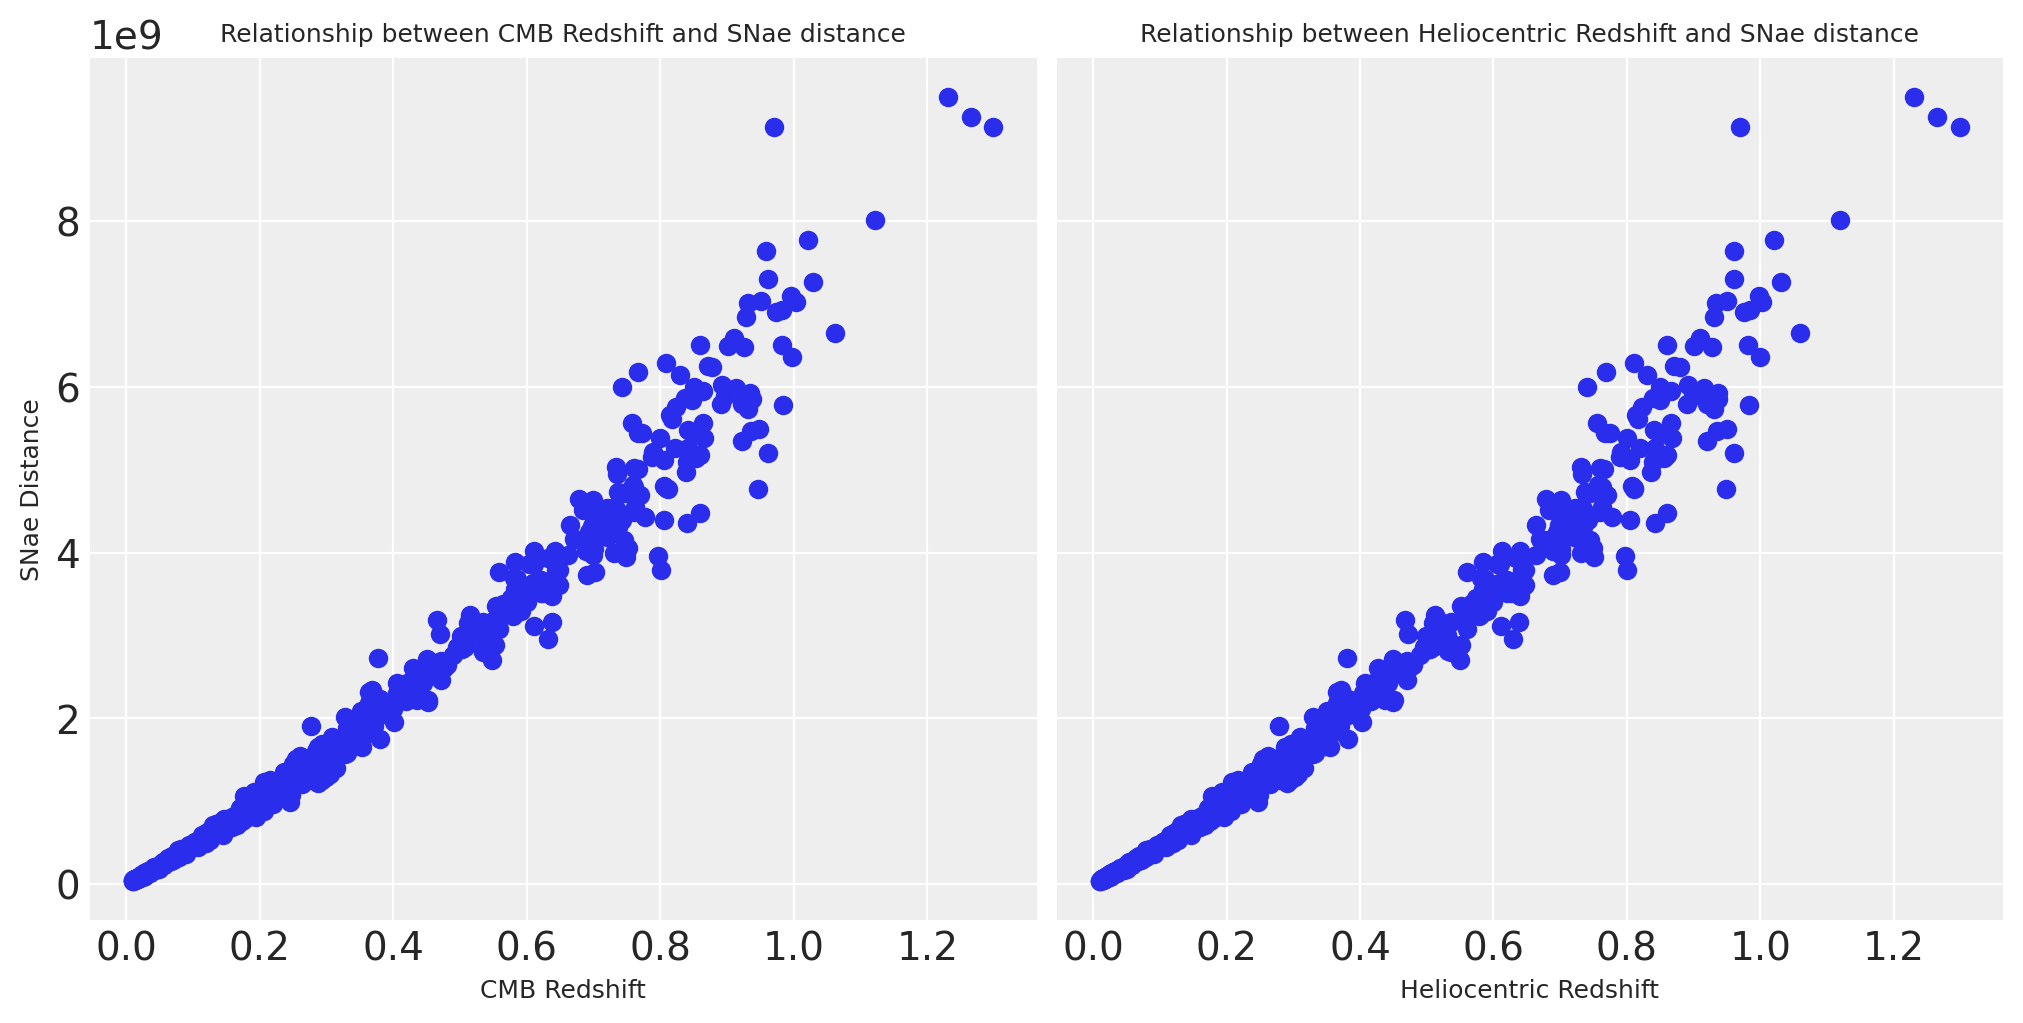

In [9]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(10, 5))
ax[0].scatter(df['zcmb'], df['d'])
ax[0].set_xlabel('CMB Redshift', size=9)
ax[0].set_ylabel('SNae Distance', size=9)
ax[0].set_title('Relationship between CMB Redshift and SNae distance', size=9)

ax[1].scatter(df['zhel'], df['d'])
ax[1].set_xlabel('Heliocentric Redshift', size=9)
ax[1].set_title('Relationship between Heliocentric Redshift and SNae distance', size=9)

fig.show()

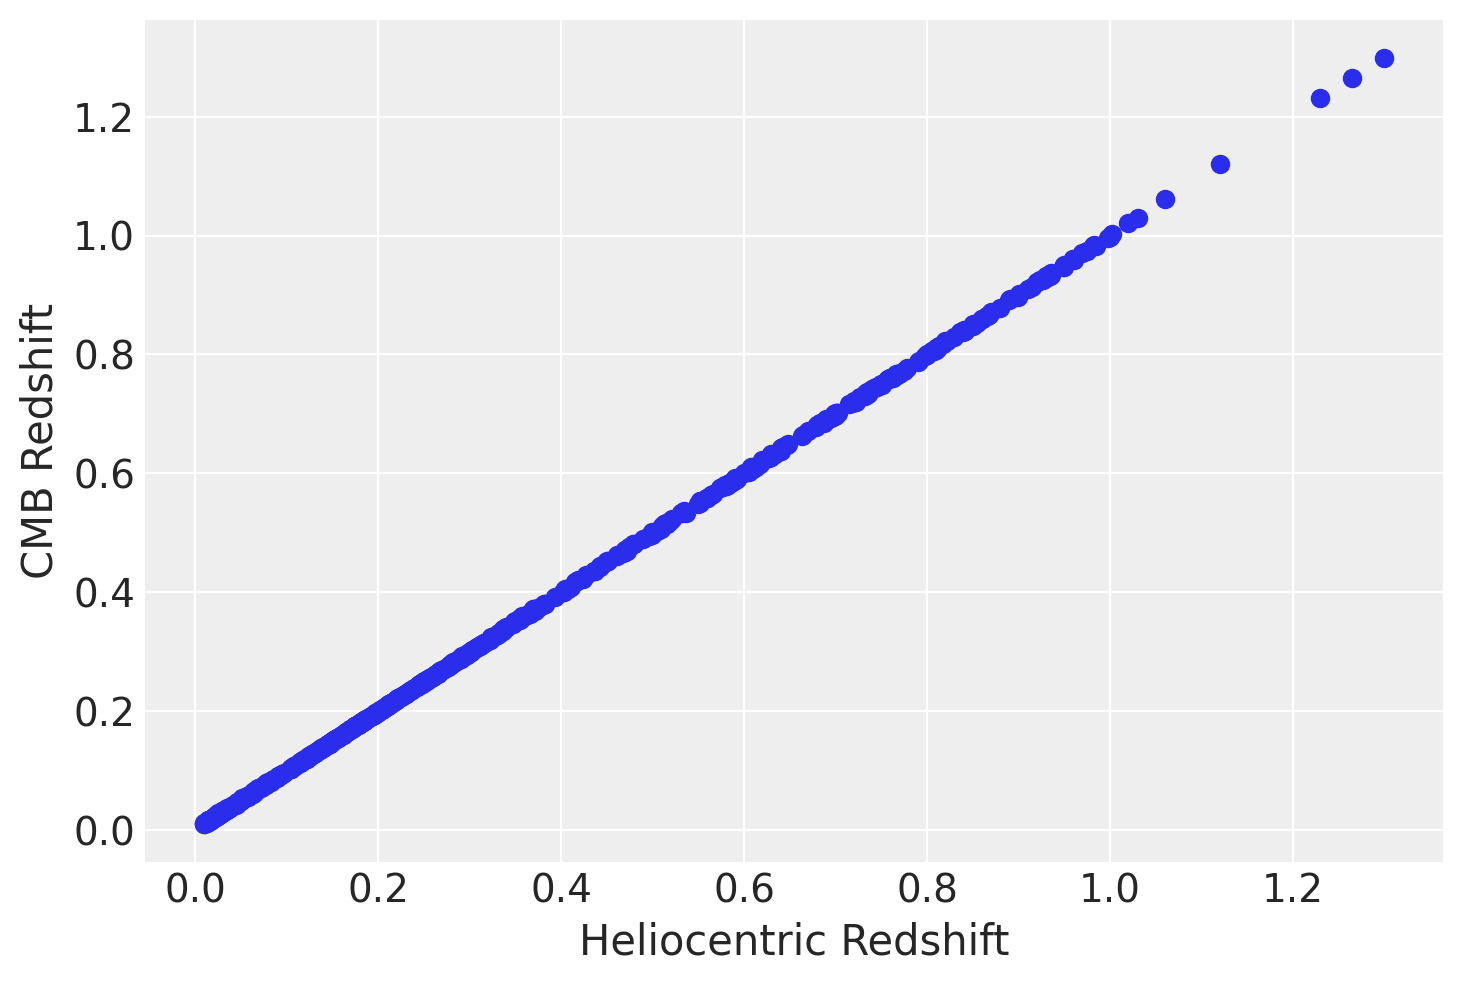

In [10]:
plt.scatter(df['zhel'], df['zcmb'])
plt.xlabel('Heliocentric Redshift')
plt.ylabel('CMB Redshift')
plt.show()

Mean difference between zcmb and zhel: -0.0006
Std of difference between zcmb and zhel: 0.0012


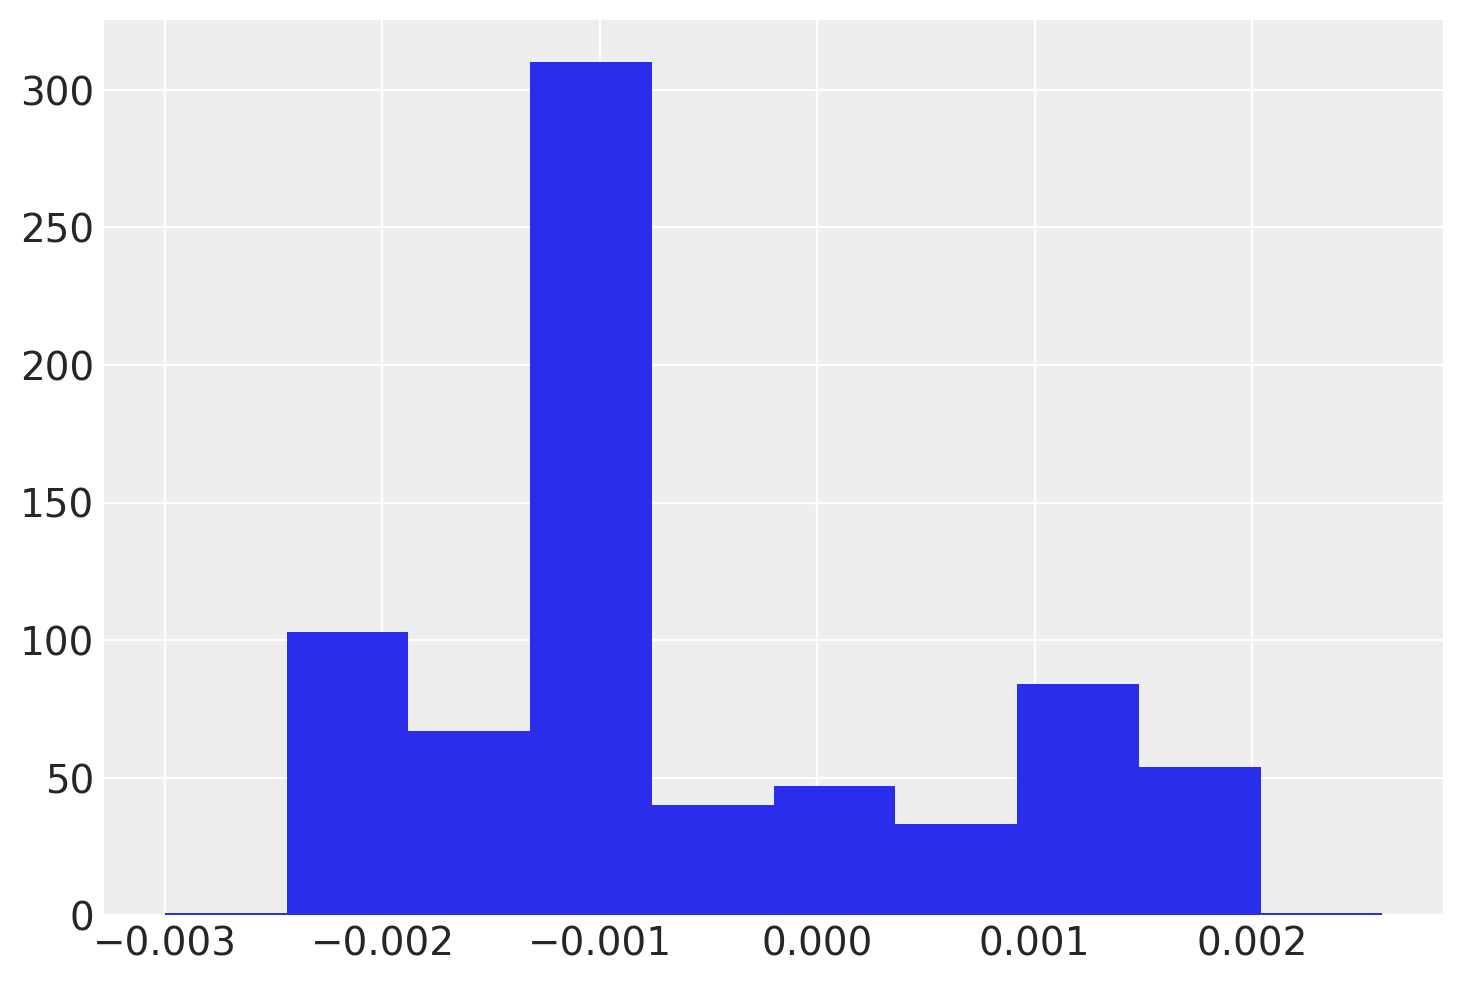

In [11]:
diff_mean = np.mean(df['zcmb'] - df['zhel'])
diff_std = np.std(df['zcmb'] - df['zhel'])
print(f'Mean difference between zcmb and zhel: {round(diff_mean, 4)}')
print(f'Std of difference between zcmb and zhel: {round(diff_std, 4)}')
plt.hist(df['zcmb'] - df['zhel'])
plt.show()

From literature it is identified that `zhel` and `zcmb` are the redshifts from two different reference points. `zhel` is measured relative to the sun and `zcmb` is measured relative to the frame of CMB. The Heliocentric redshift accounts for motion of the Earth and the solar system with respect to the observed object while the CMB redshift accounts for the motion of solar system relative to the universal rest frame.

Although these two values are almost same for nearby objects, CMB redshift is often used as an universal standard in cosmology.

In [12]:
reg_1 = stats.linregress(df['zcmb'], df['d'])
print(reg_1)

LinregressResult(slope=6667961155.405358, intercept=-278308795.7457864, rvalue=0.985877500159918, pvalue=0.0, stderr=41694036.47083354, intercept_stderr=17760795.98188081)


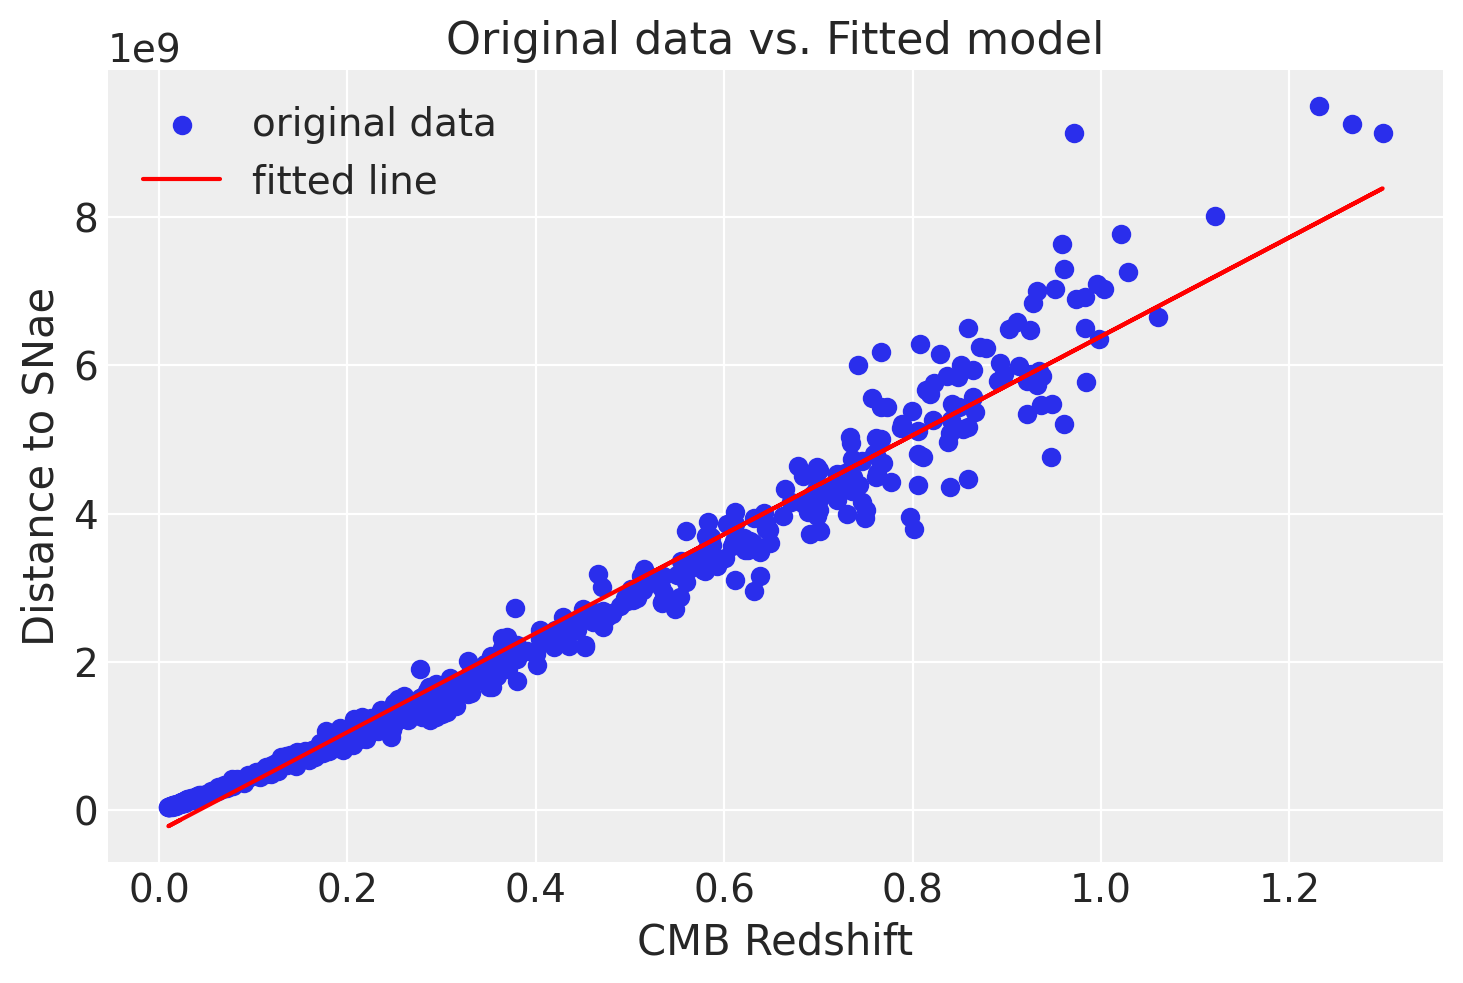

In [13]:
y_pred = reg_1.intercept + (df['zcmb'] * reg_1.slope)
residual = y_pred - df['d']

plt.scatter(df['zcmb'], df['d'], label='original data')
plt.plot(df['zcmb'], y_pred, 'r', label='fitted line')
plt.xlabel('CMB Redshift')
plt.ylabel('Distance to SNae')
plt.title('Original data vs. Fitted model')
plt.legend()
plt.show()

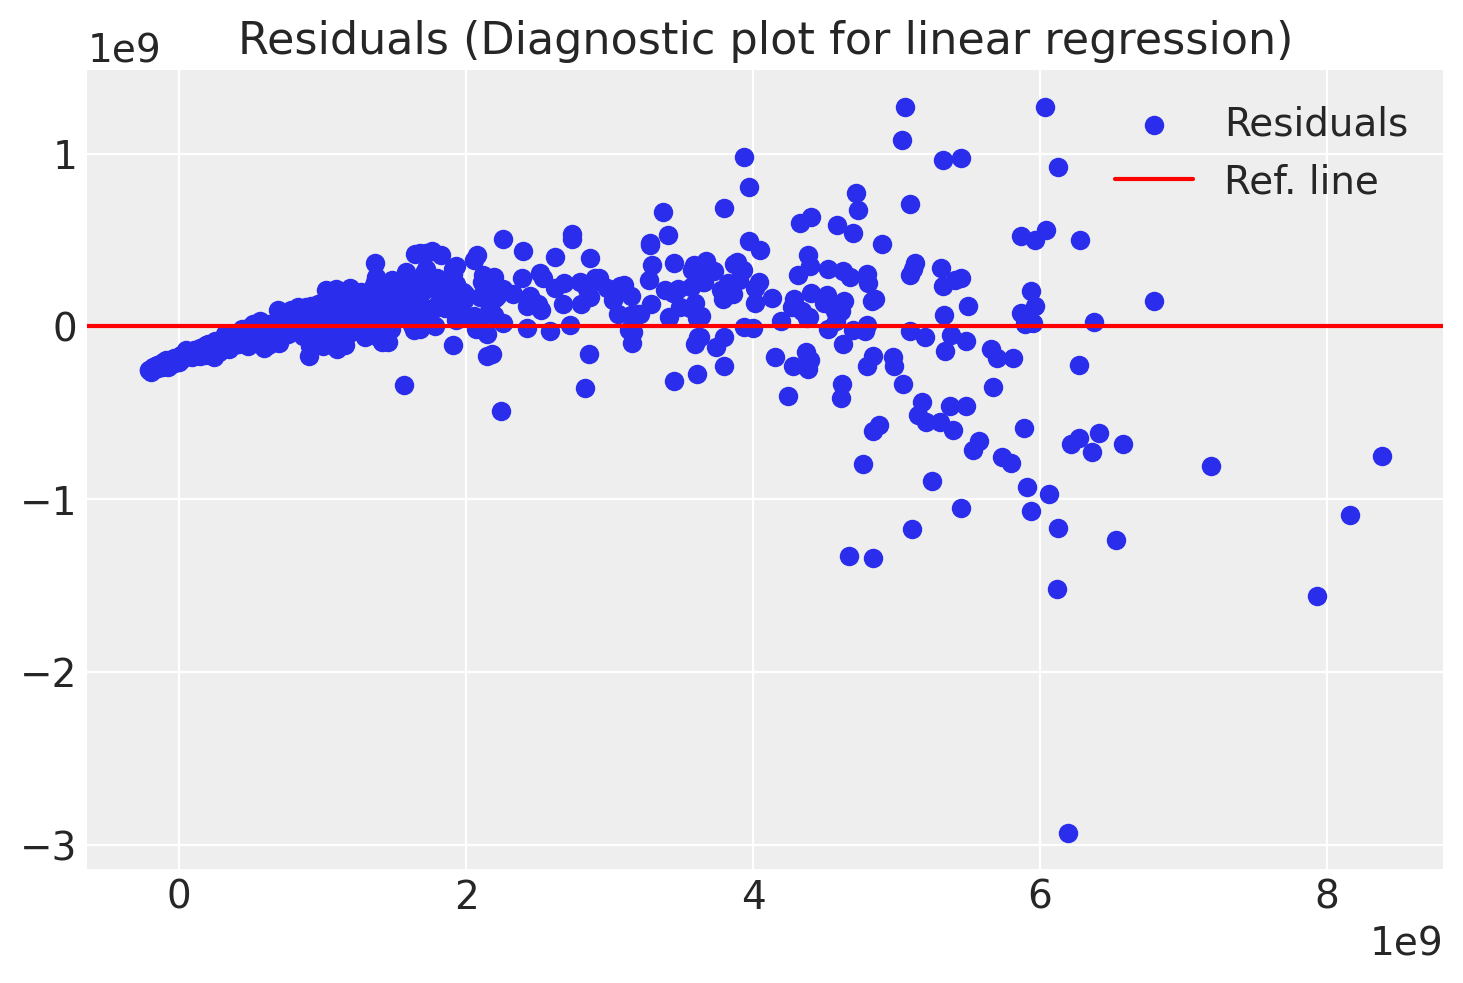

In [14]:
plt.scatter(y_pred, residual, label='Residuals')
plt.axhline(y=0, color='r', label='Ref. line')
plt.title('Residuals (Diagnostic plot for linear regression)')
plt.legend()
plt.show()

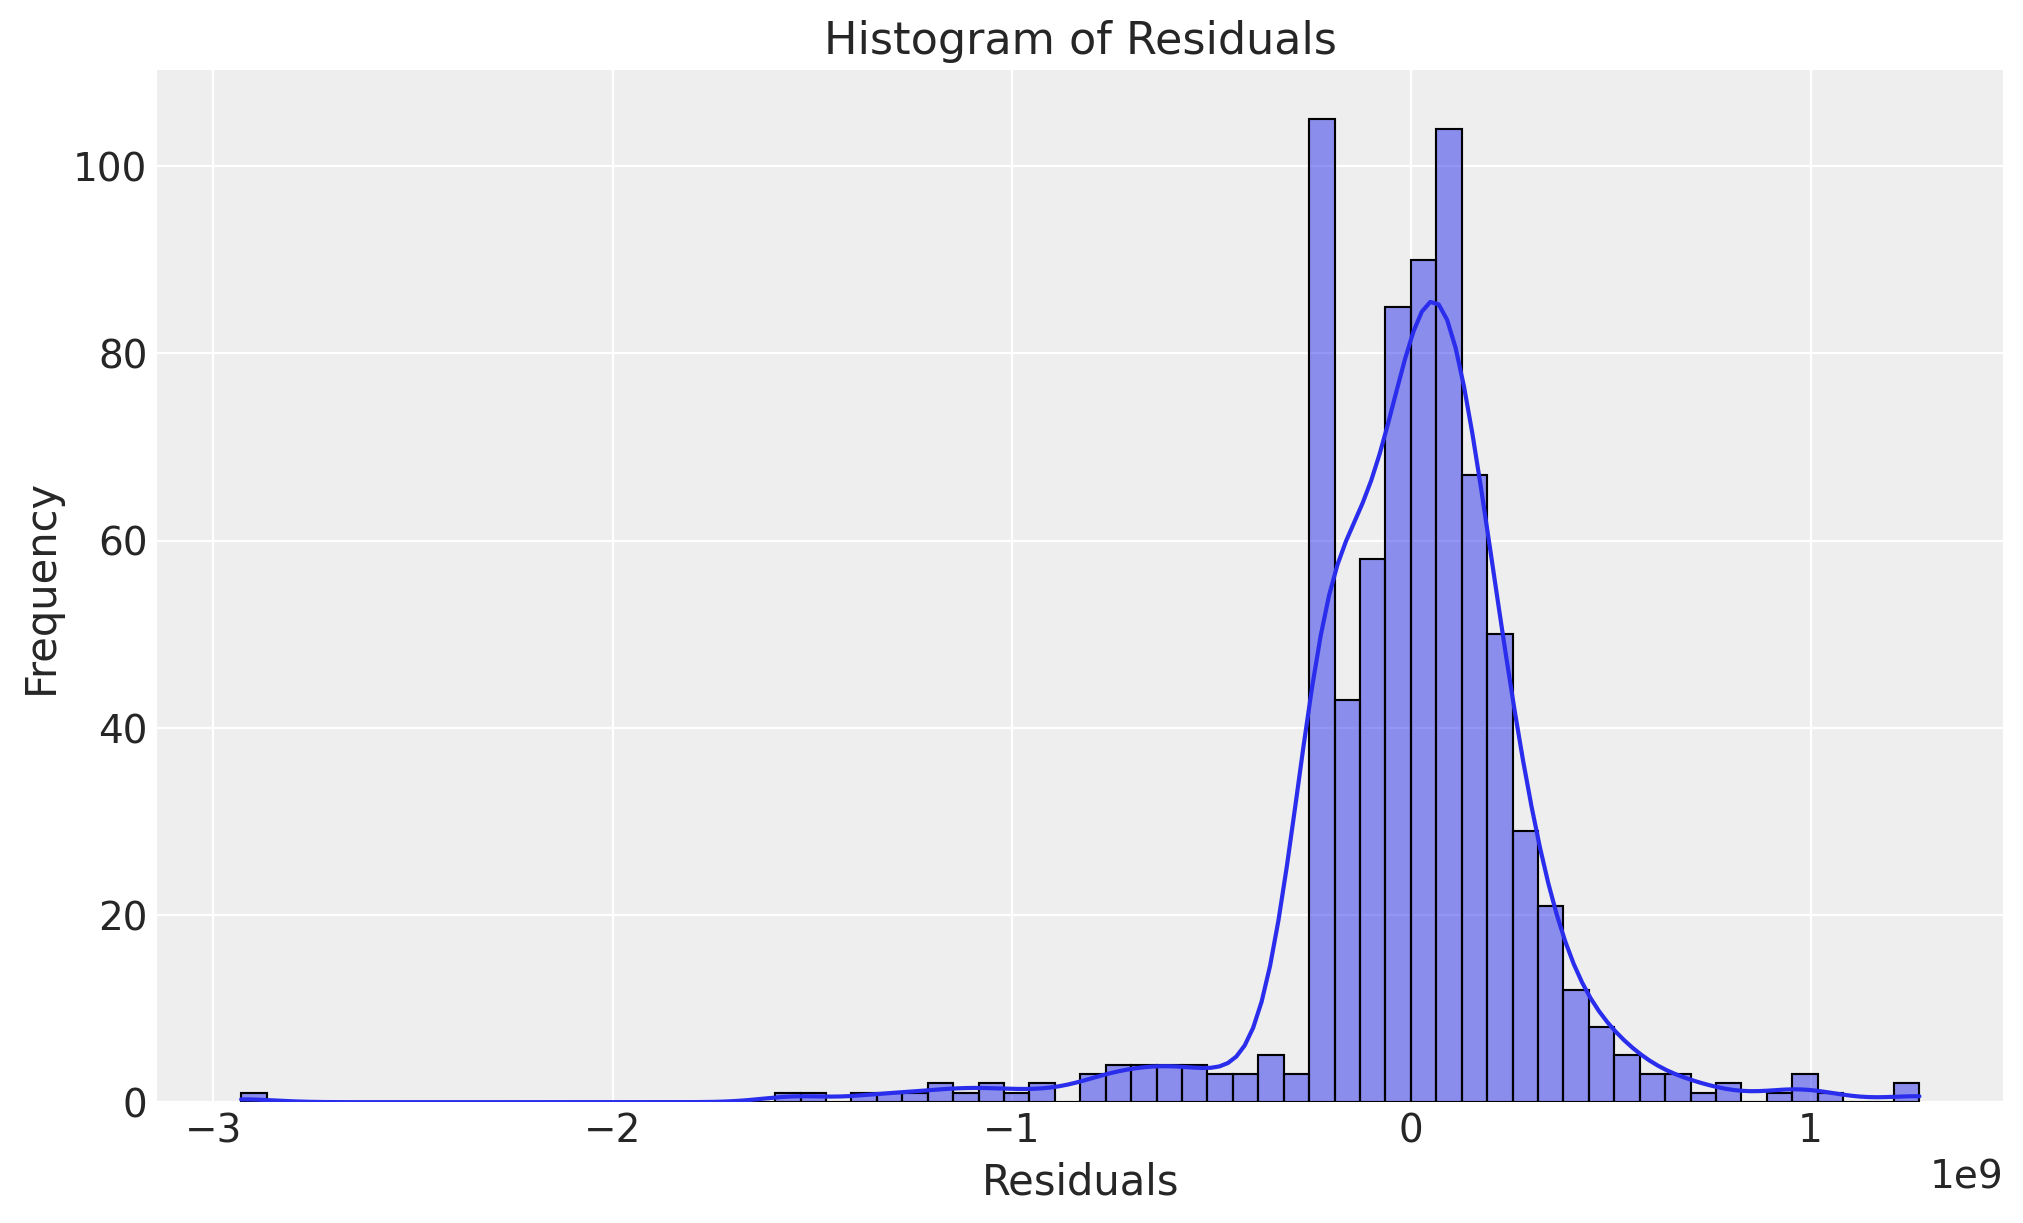

In [15]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residual, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [16]:
# performing the durbin-watson test for autocorrelation
n_res = len(residual)
stride_1 = np.array(residual[:-1])
stride_2 = np.array(residual[1:])

dw = np.sum((stride_2 - stride_1) ** 2) / np.sum(np.array(residual) ** 2)
print(f'DW test value: {dw}')

DW test value: 1.6061981691385316


Since the value is closer to 2, there is a slight but no significant autocorrelation between the variables.

The test of independence is succeeded.

From the initial scatter plot, we have evidence of linearity.


In [17]:
# testing homoscedasticity
from statsmodels import api as stats_api
from statsmodels.stats.diagnostic import het_breuschpagan

## H0: Homoscedasticity is present
## Ha: No Homoscedasticity is present

bp_x = stats_api.add_constant(df['zcmb'])
bp_test = het_breuschpagan(pd.DataFrame(residual), bp_x)
print(f'BP test statistic: {bp_test[0]}')
print(f'BP test p-value: {bp_test[1]}')

BP test statistic: 101.97974528221783
BP test p-value: 5.6092373655638904e-24


Since p-value (0.0005 e-20) < 0.05, we reject the Null Hypothesis $H_{0}$. So there is no homoscedasticity present.

Potential fix is to Transform the variables.


In [18]:
# applying box-cox transformations

d_transf, d_lam = stats.boxcox(df['d'])
print(d_lam)

zcmb_transf, zcmb_lam = stats.boxcox(df['zcmb'])
print(zcmb_lam)

0.21313064383072983
0.2957364660751139


This essentially means the transformed distance is $d_t = \frac{d^\lambda_{1} - 1}{\lambda_{1}}$ since the $\lambda \neq 0$.  

Similarly, $Zcmb_{t} = \frac{Zcmb^\lambda_{2} - 1}{\lambda_{2}}$ since the $\lambda \neq 0$.  

Here the $\lambda_{1}$ was 0.21313064383072983.  
Here the $\lambda_{2}$ was 0.2957364660751139.

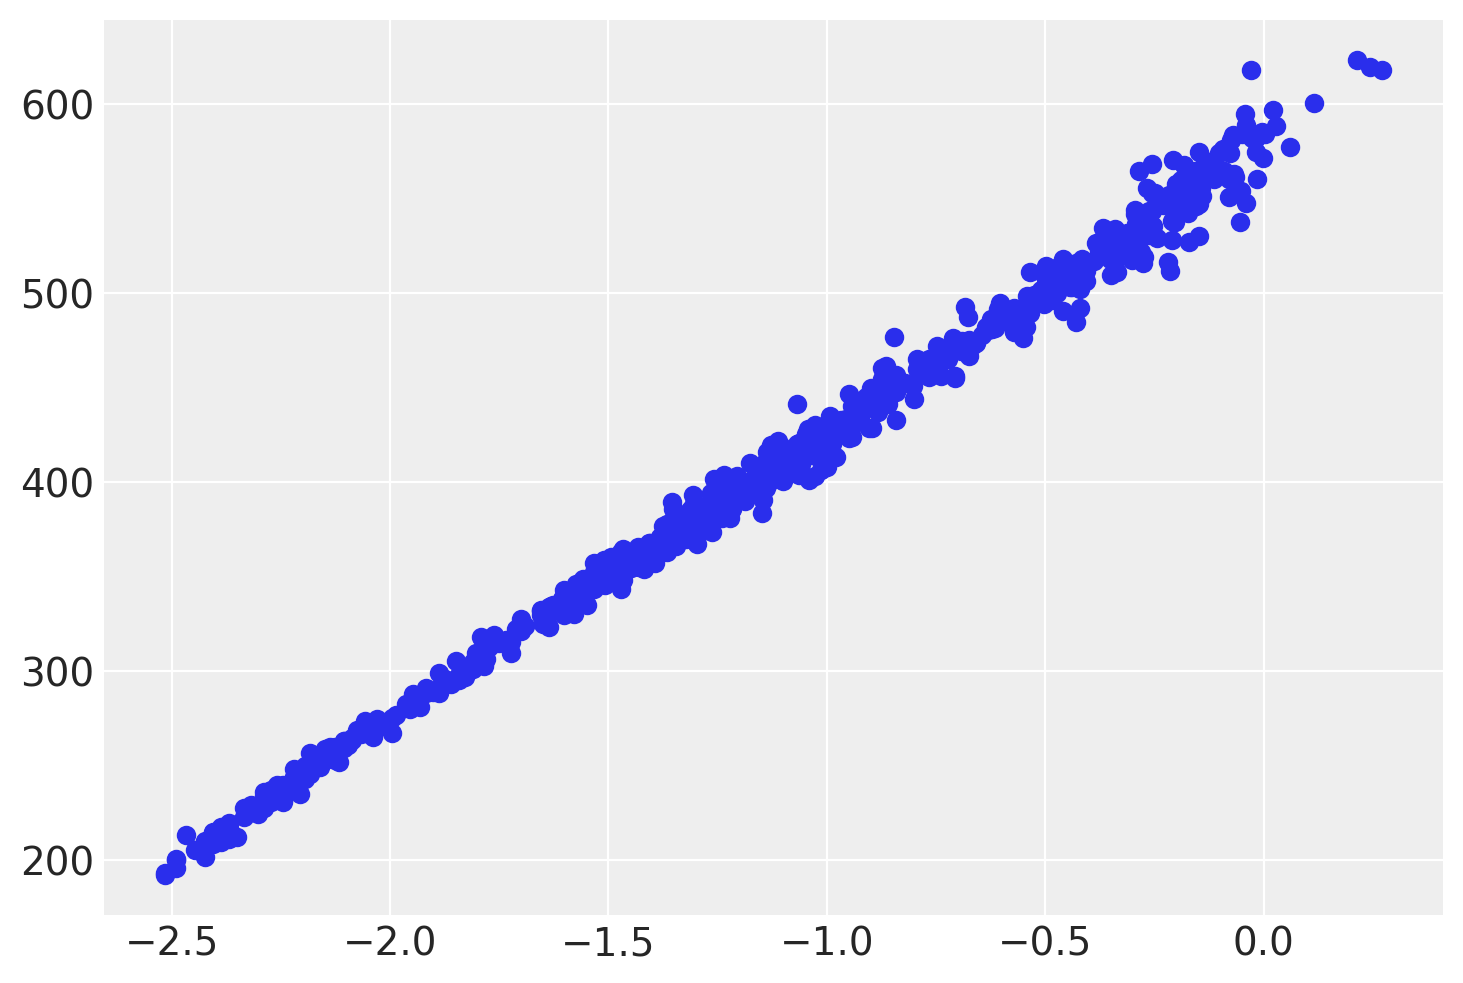

In [19]:
plt.scatter(zcmb_transf, d_transf)

In [20]:
reg_2 = stats.linregress(zcmb_transf, d_transf)
print(reg_2)

LinregressResult(slope=151.1865542391289, intercept=576.8540085679791, rvalue=0.9971865787995767, pvalue=0.0, stderr=0.41834565306523996, intercept_stderr=0.5618845492189087)


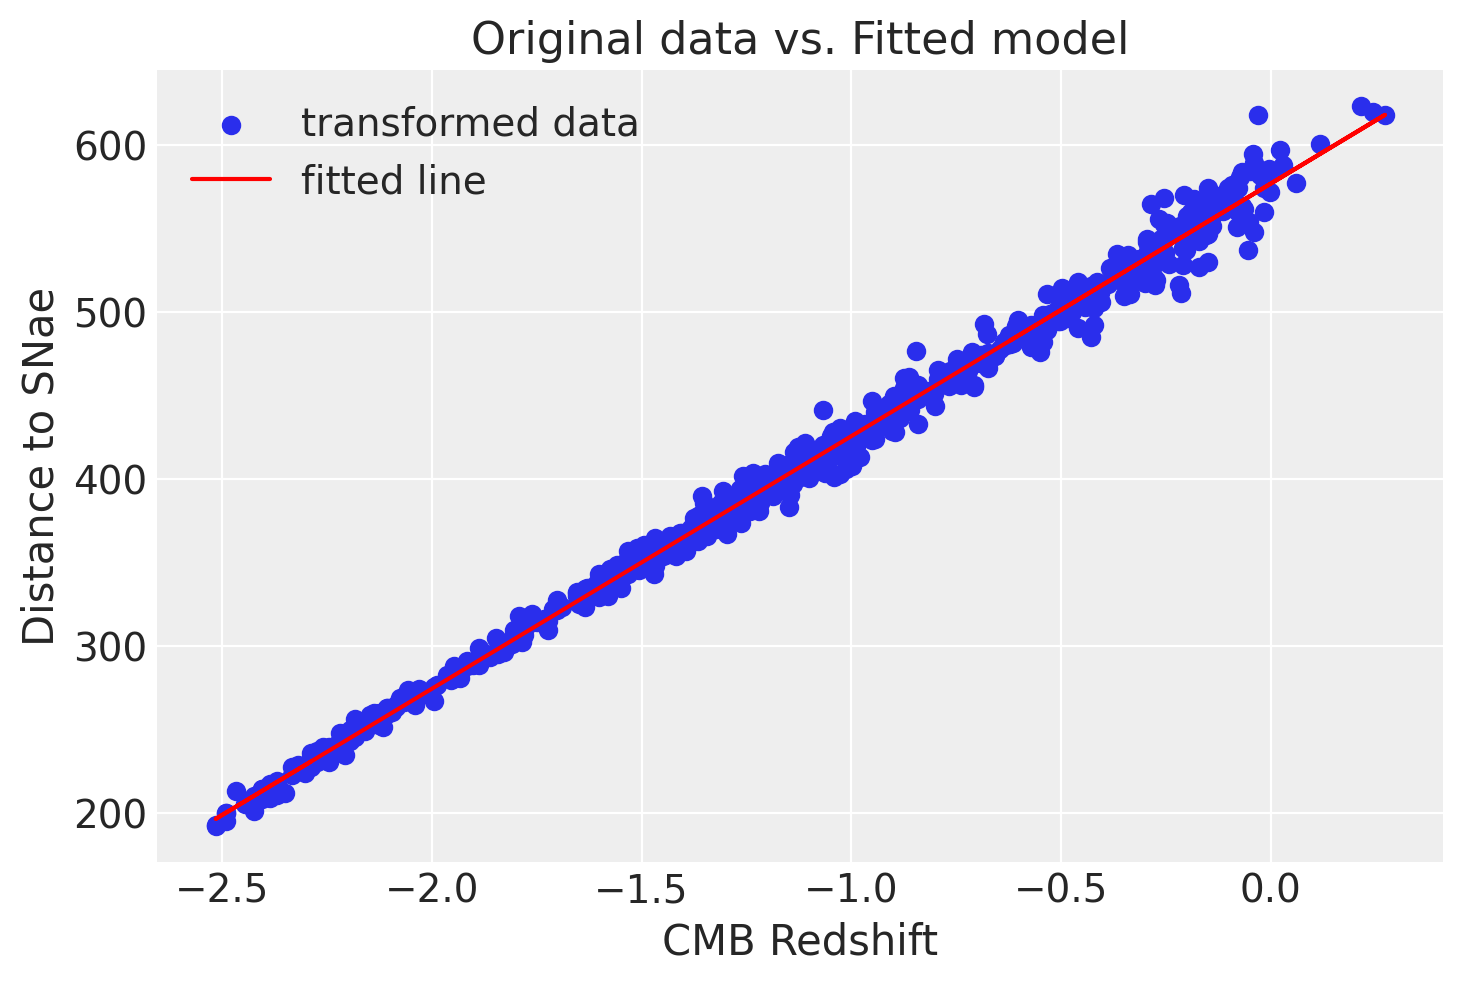

In [21]:
y_pred2 = reg_2.intercept + (zcmb_transf * reg_2.slope)
residual2 = y_pred2 - d_transf

plt.scatter(zcmb_transf, d_transf, label='transformed data')
plt.plot(zcmb_transf, y_pred2, 'r', label='fitted line')
plt.xlabel('CMB Redshift')
plt.ylabel('Distance to SNae')
plt.title('Original data vs. Fitted model')
plt.legend()
plt.show()

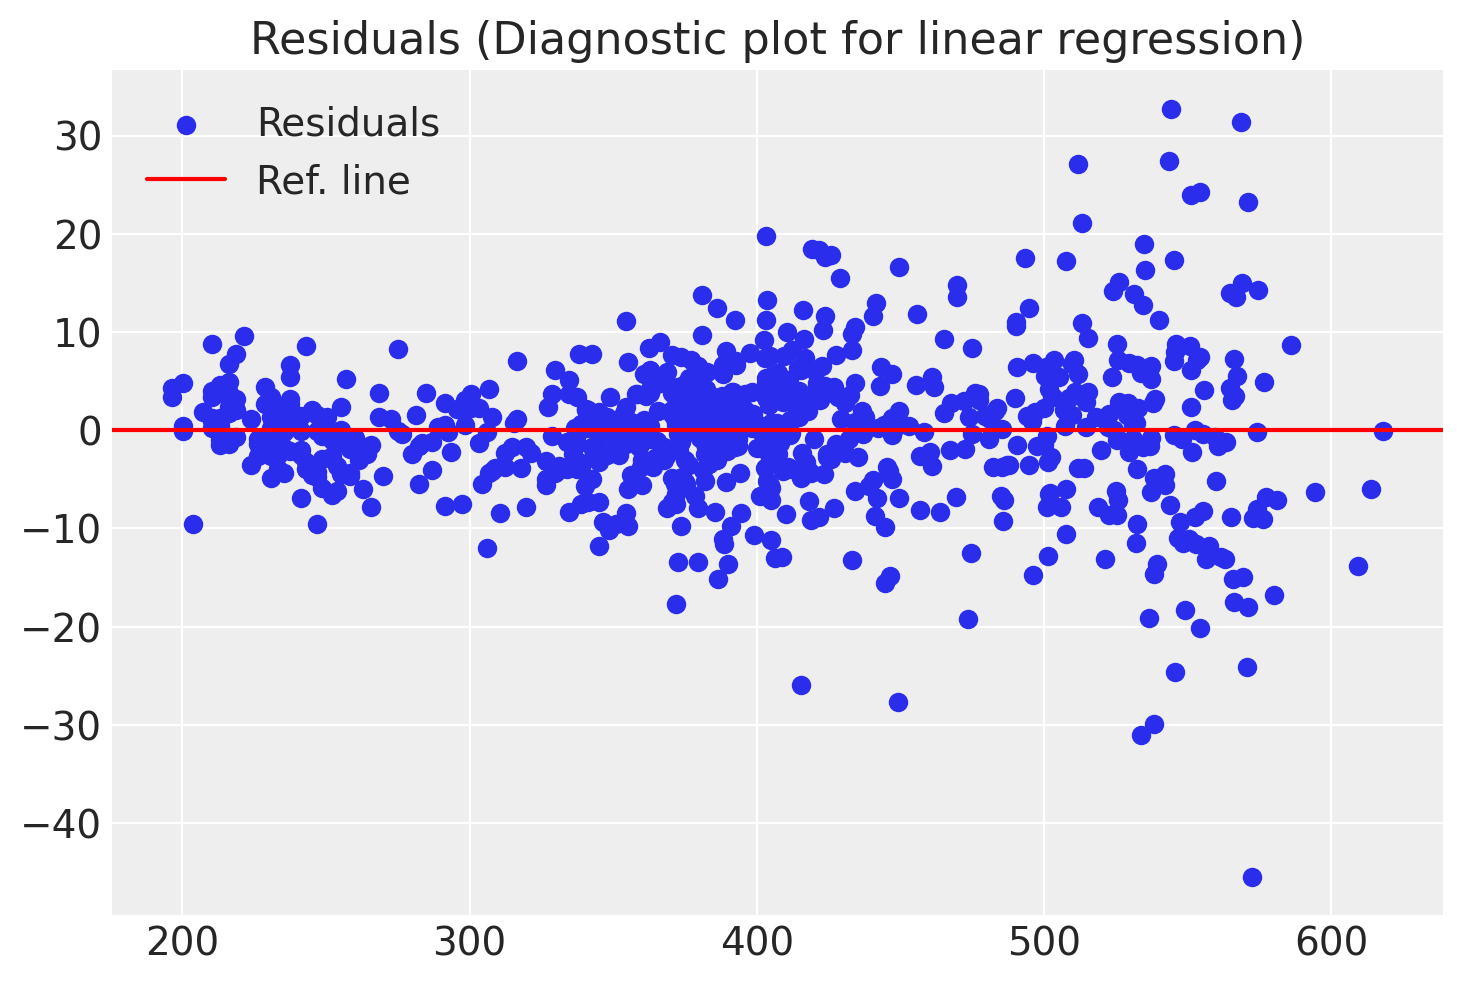

In [22]:
plt.scatter(y_pred2, residual2, label='Residuals')
plt.axhline(y=0, color='r', label='Ref. line')
plt.title('Residuals (Diagnostic plot for linear regression)')
plt.legend()
plt.show()

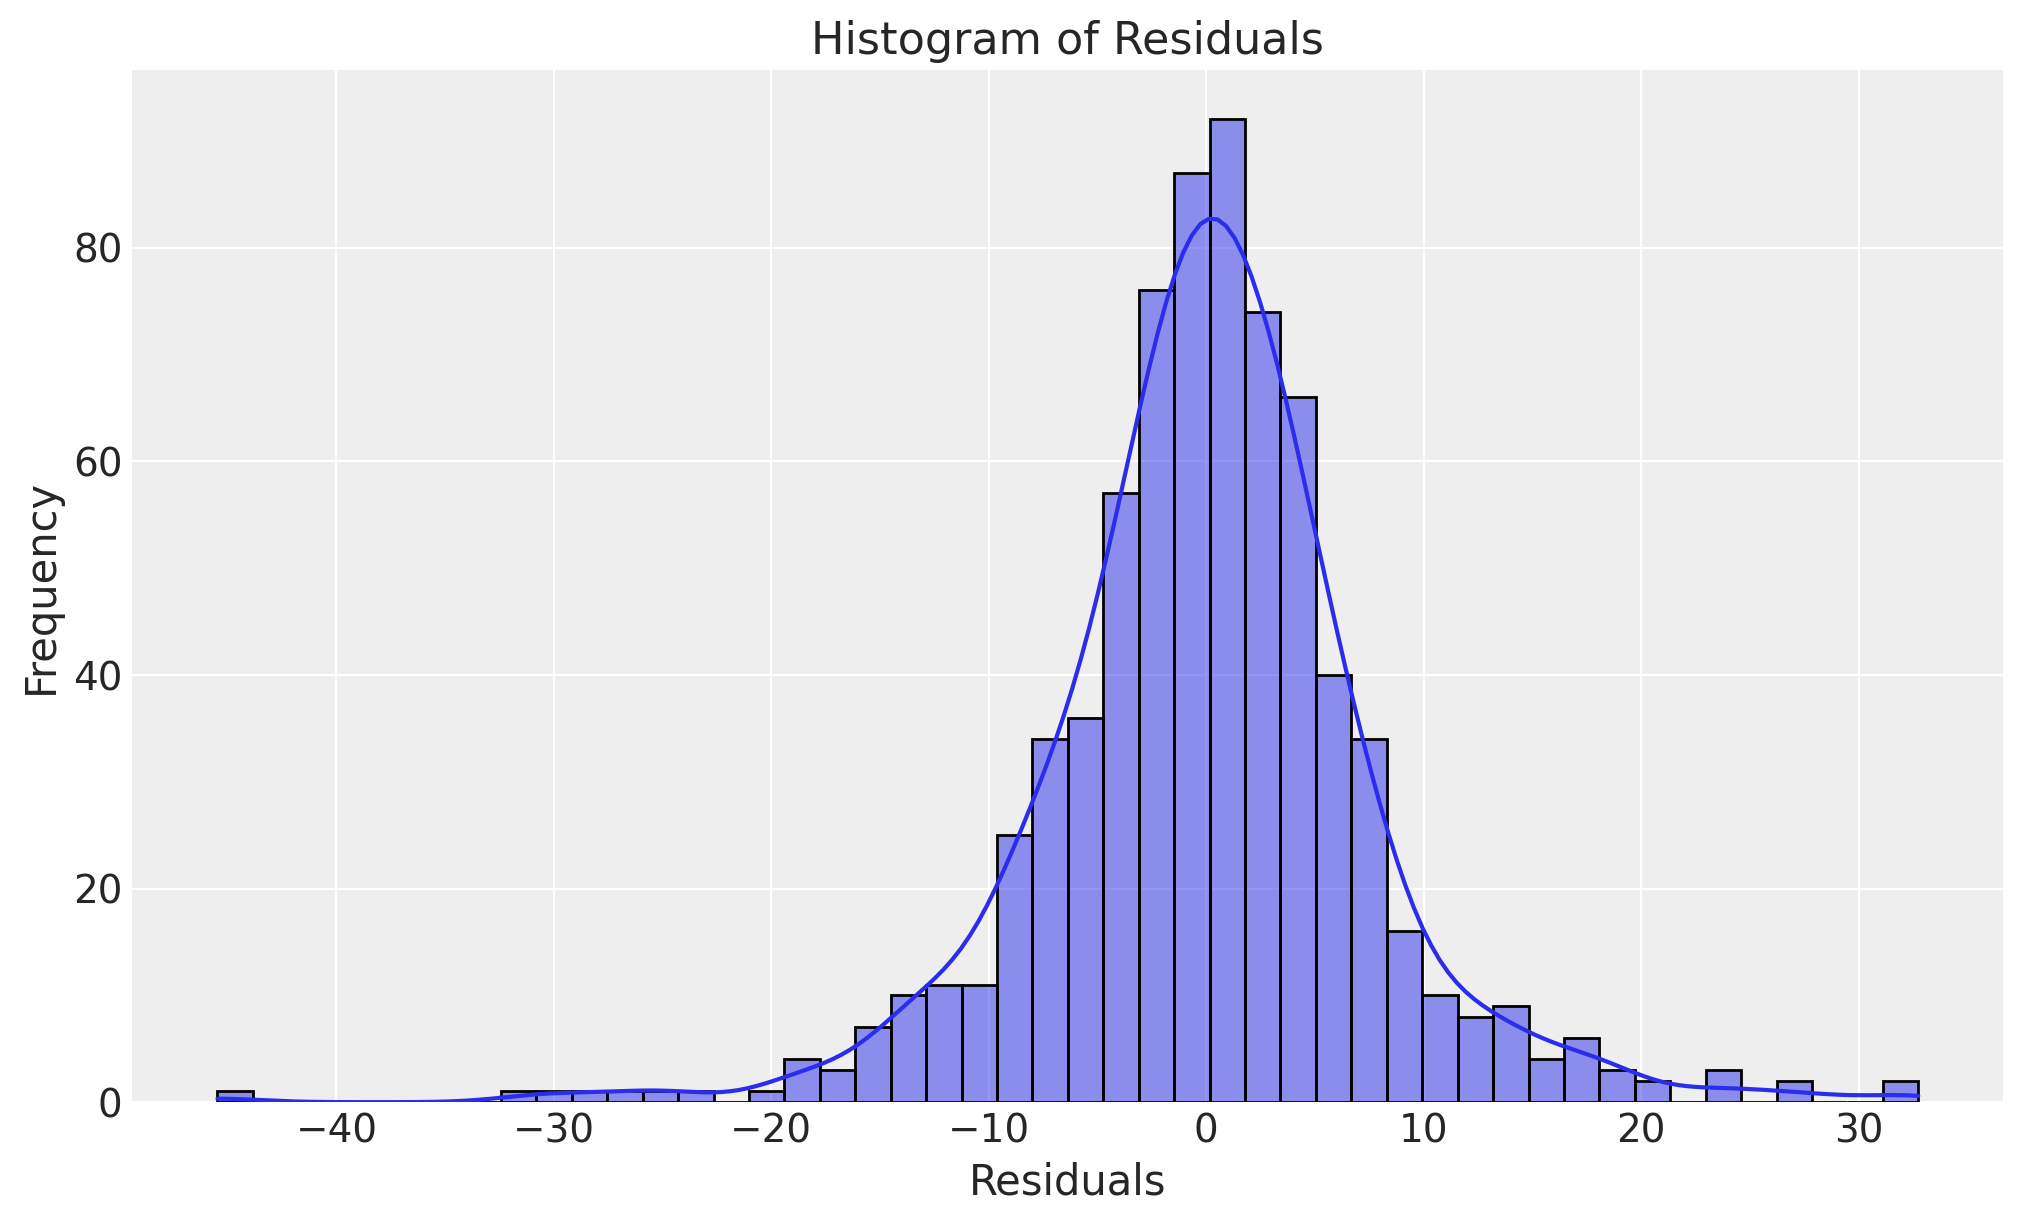

In [23]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residual2, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

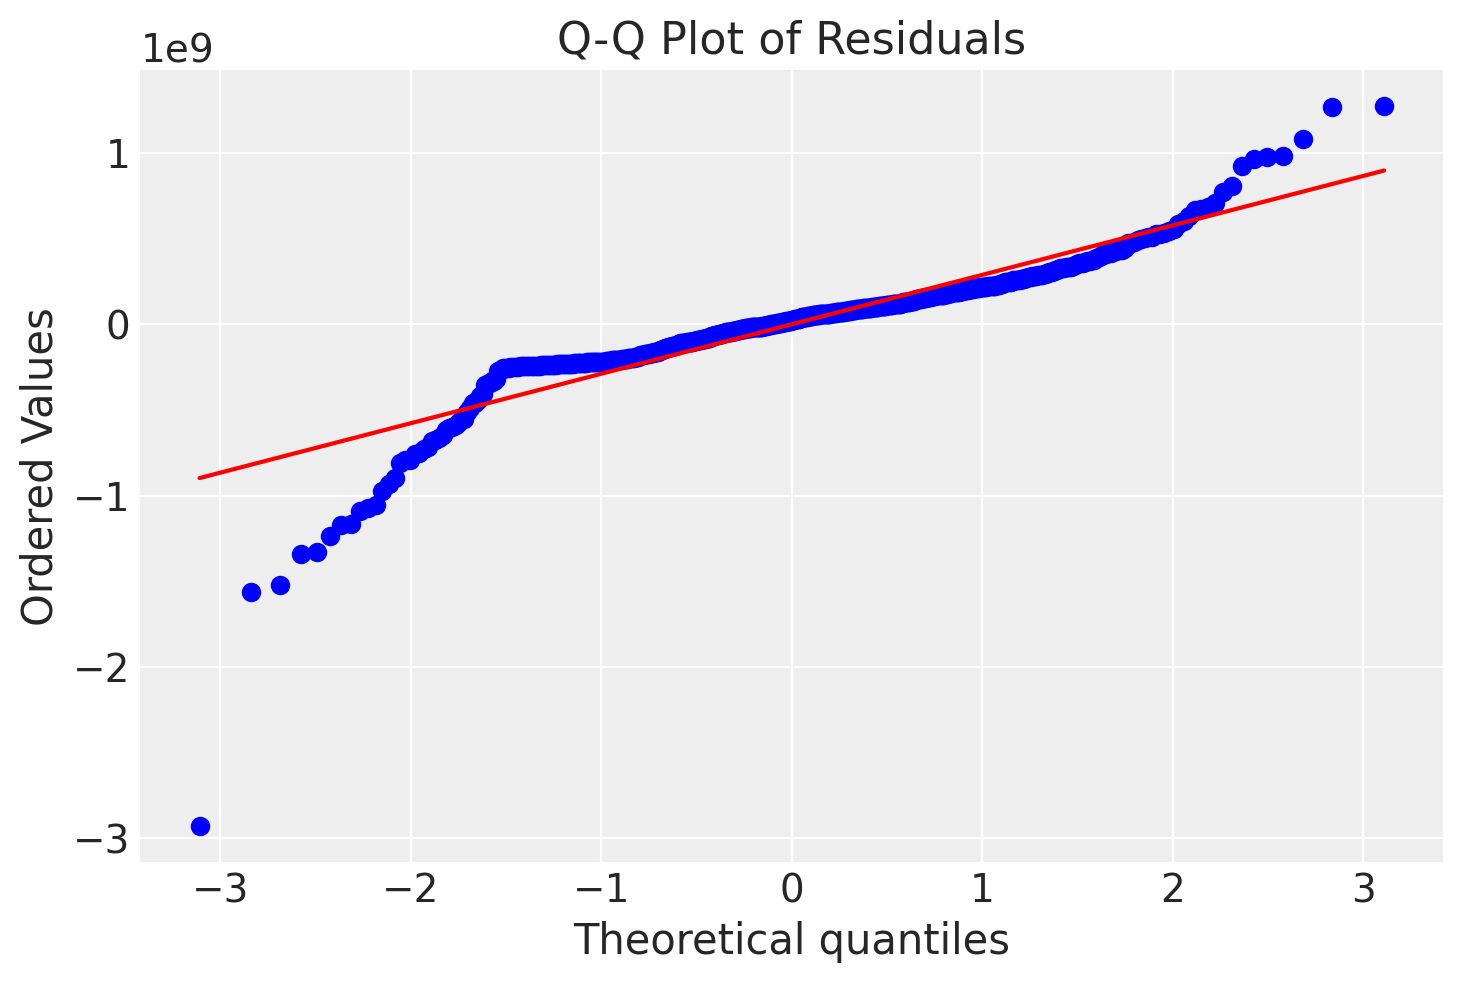

In [24]:
# normal QQ plots
stats.probplot(residual, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

Approximating the $\lambda$ to be 0.25 for simple understanding. Effectively, we are taking $d^{1/4}$ and $Z_{cmb}^{1/4}$.

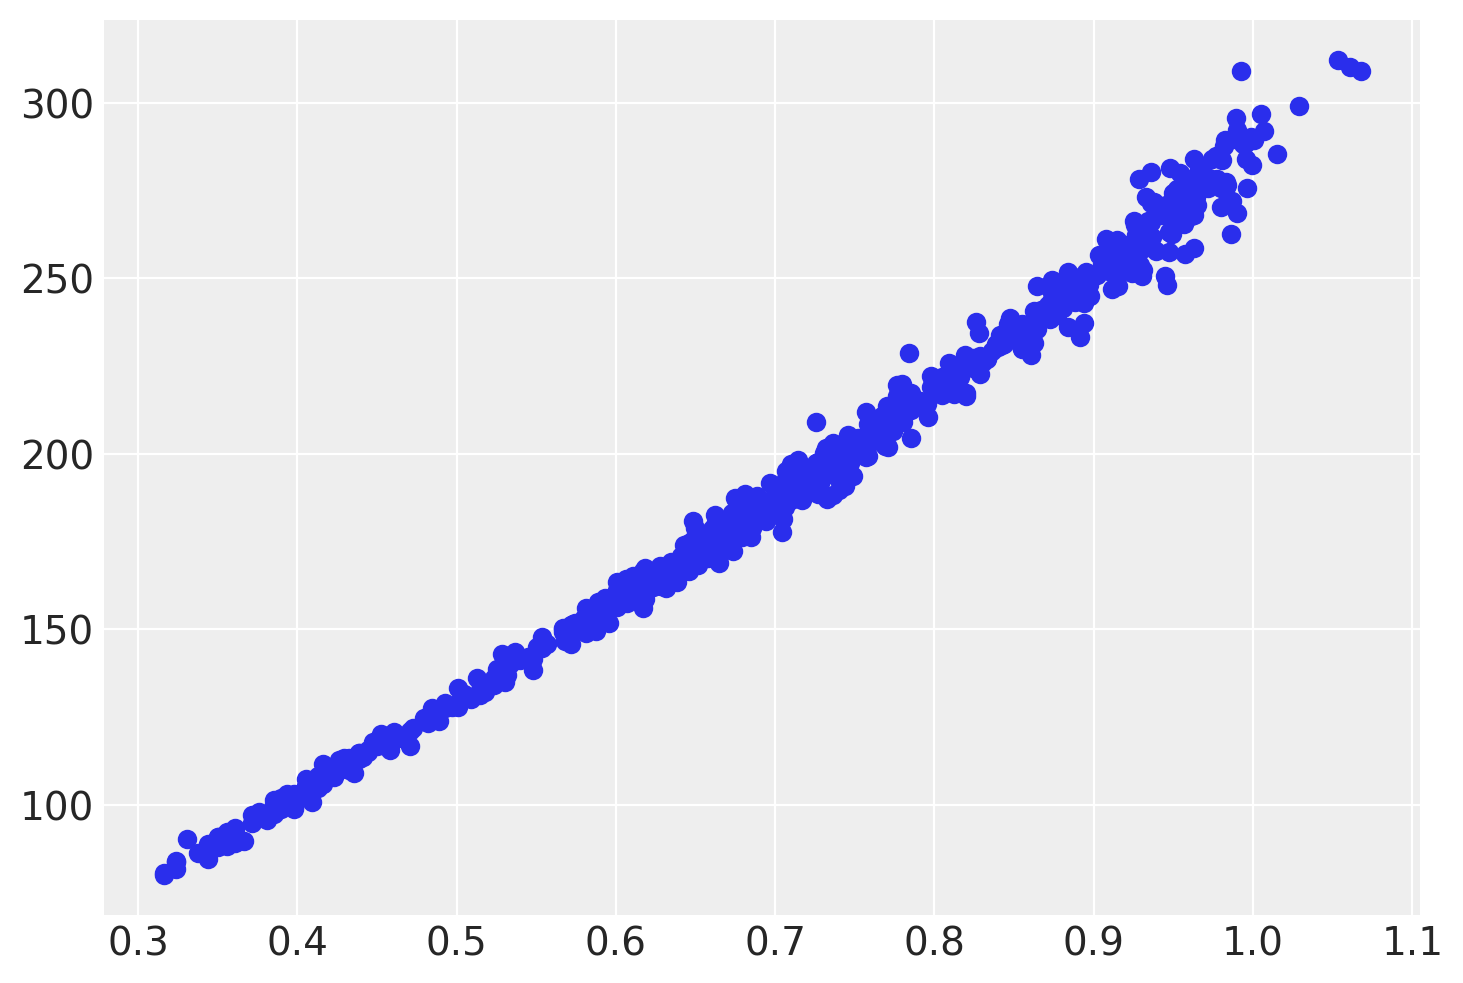

In [25]:
plt.scatter(df['zcmb']**0.25, df['d']**0.25)

In [26]:
reg_3 = stats.linregress(df['zcmb']**0.25, df['d']**0.25)
print(reg_3)

LinregressResult(slope=301.35431657905957, intercept=-21.49951133617907, rvalue=0.9954257131189491, pvalue=0.0, stderr=1.0646818782982215, intercept_stderr=0.7632679880958462)


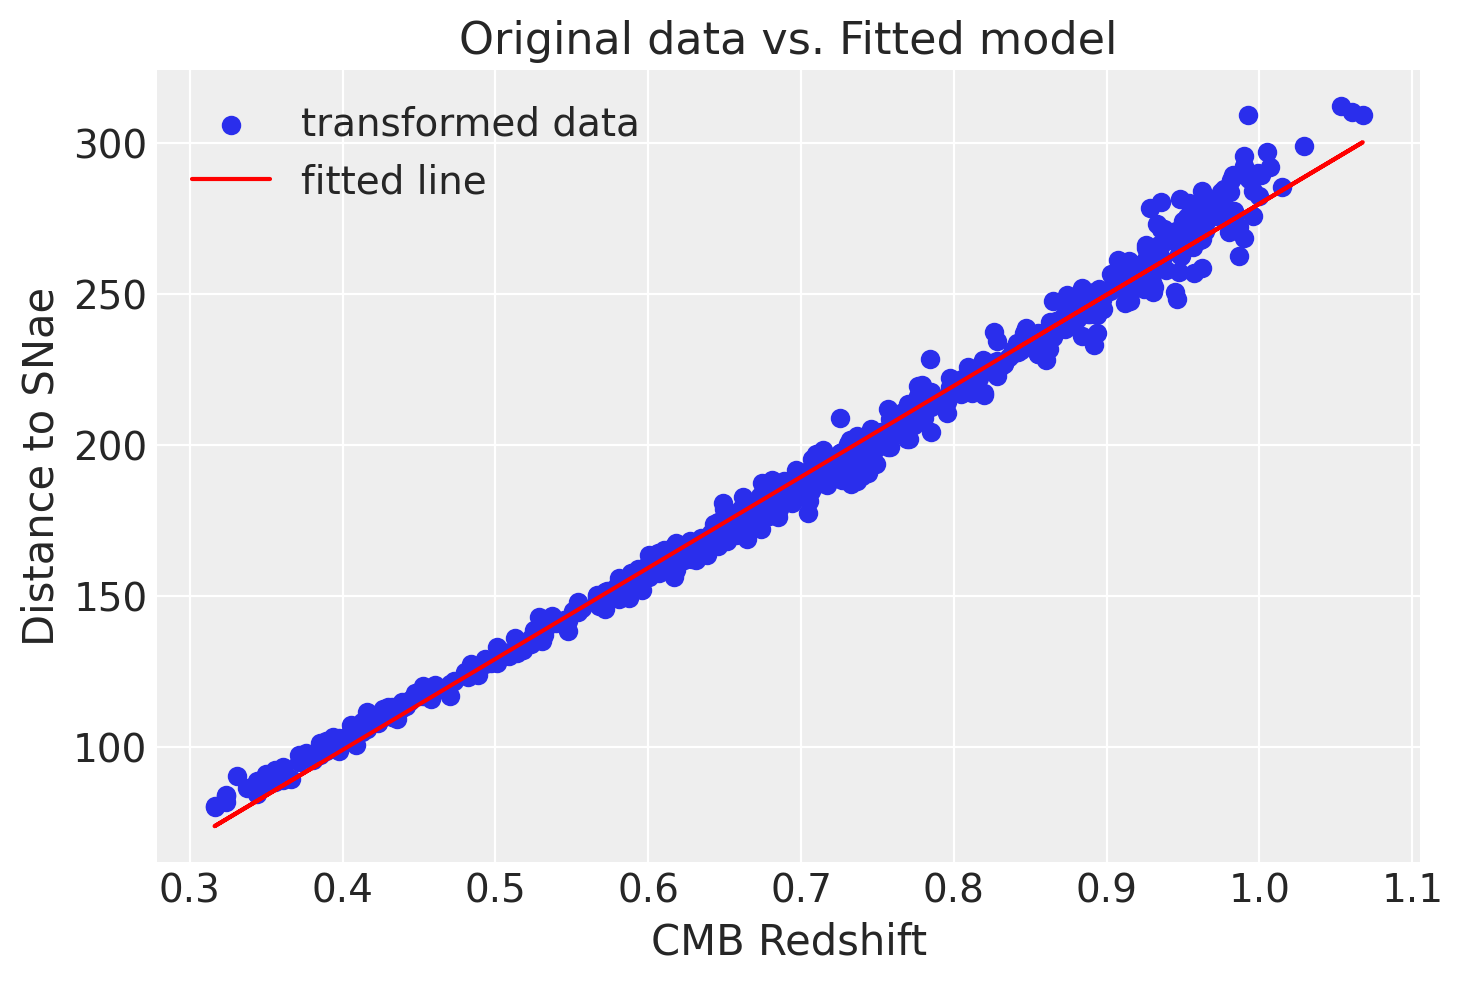

In [27]:
y_pred3 = reg_3.intercept + (df['zcmb']**0.25 * reg_3.slope)
residual3 = y_pred3 - df['d']**0.25

plt.scatter(df['zcmb']**0.25, df['d']**0.25, label='transformed data')
plt.plot(df['zcmb']**0.25, y_pred3, 'r', label='fitted line')
plt.xlabel('CMB Redshift')
plt.ylabel('Distance to SNae')
plt.title('Original data vs. Fitted model')
plt.legend()
plt.show()

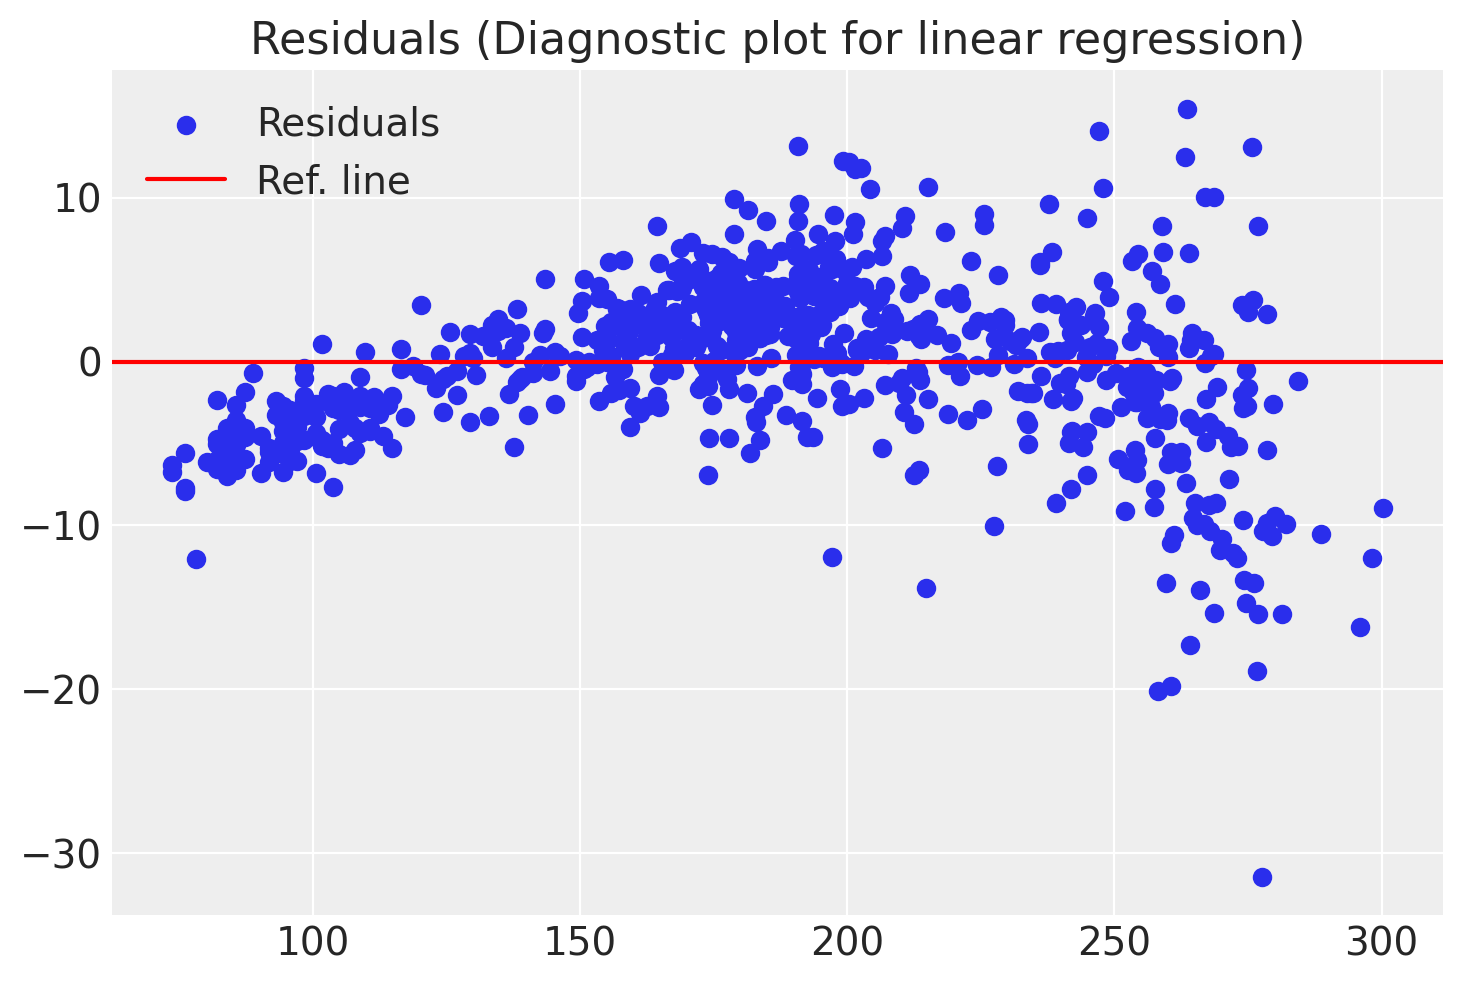

In [28]:
plt.scatter(y_pred3, residual3, label='Residuals')
plt.axhline(y=0, color='r', label='Ref. line')
plt.title('Residuals (Diagnostic plot for linear regression)')
plt.legend()
plt.show()

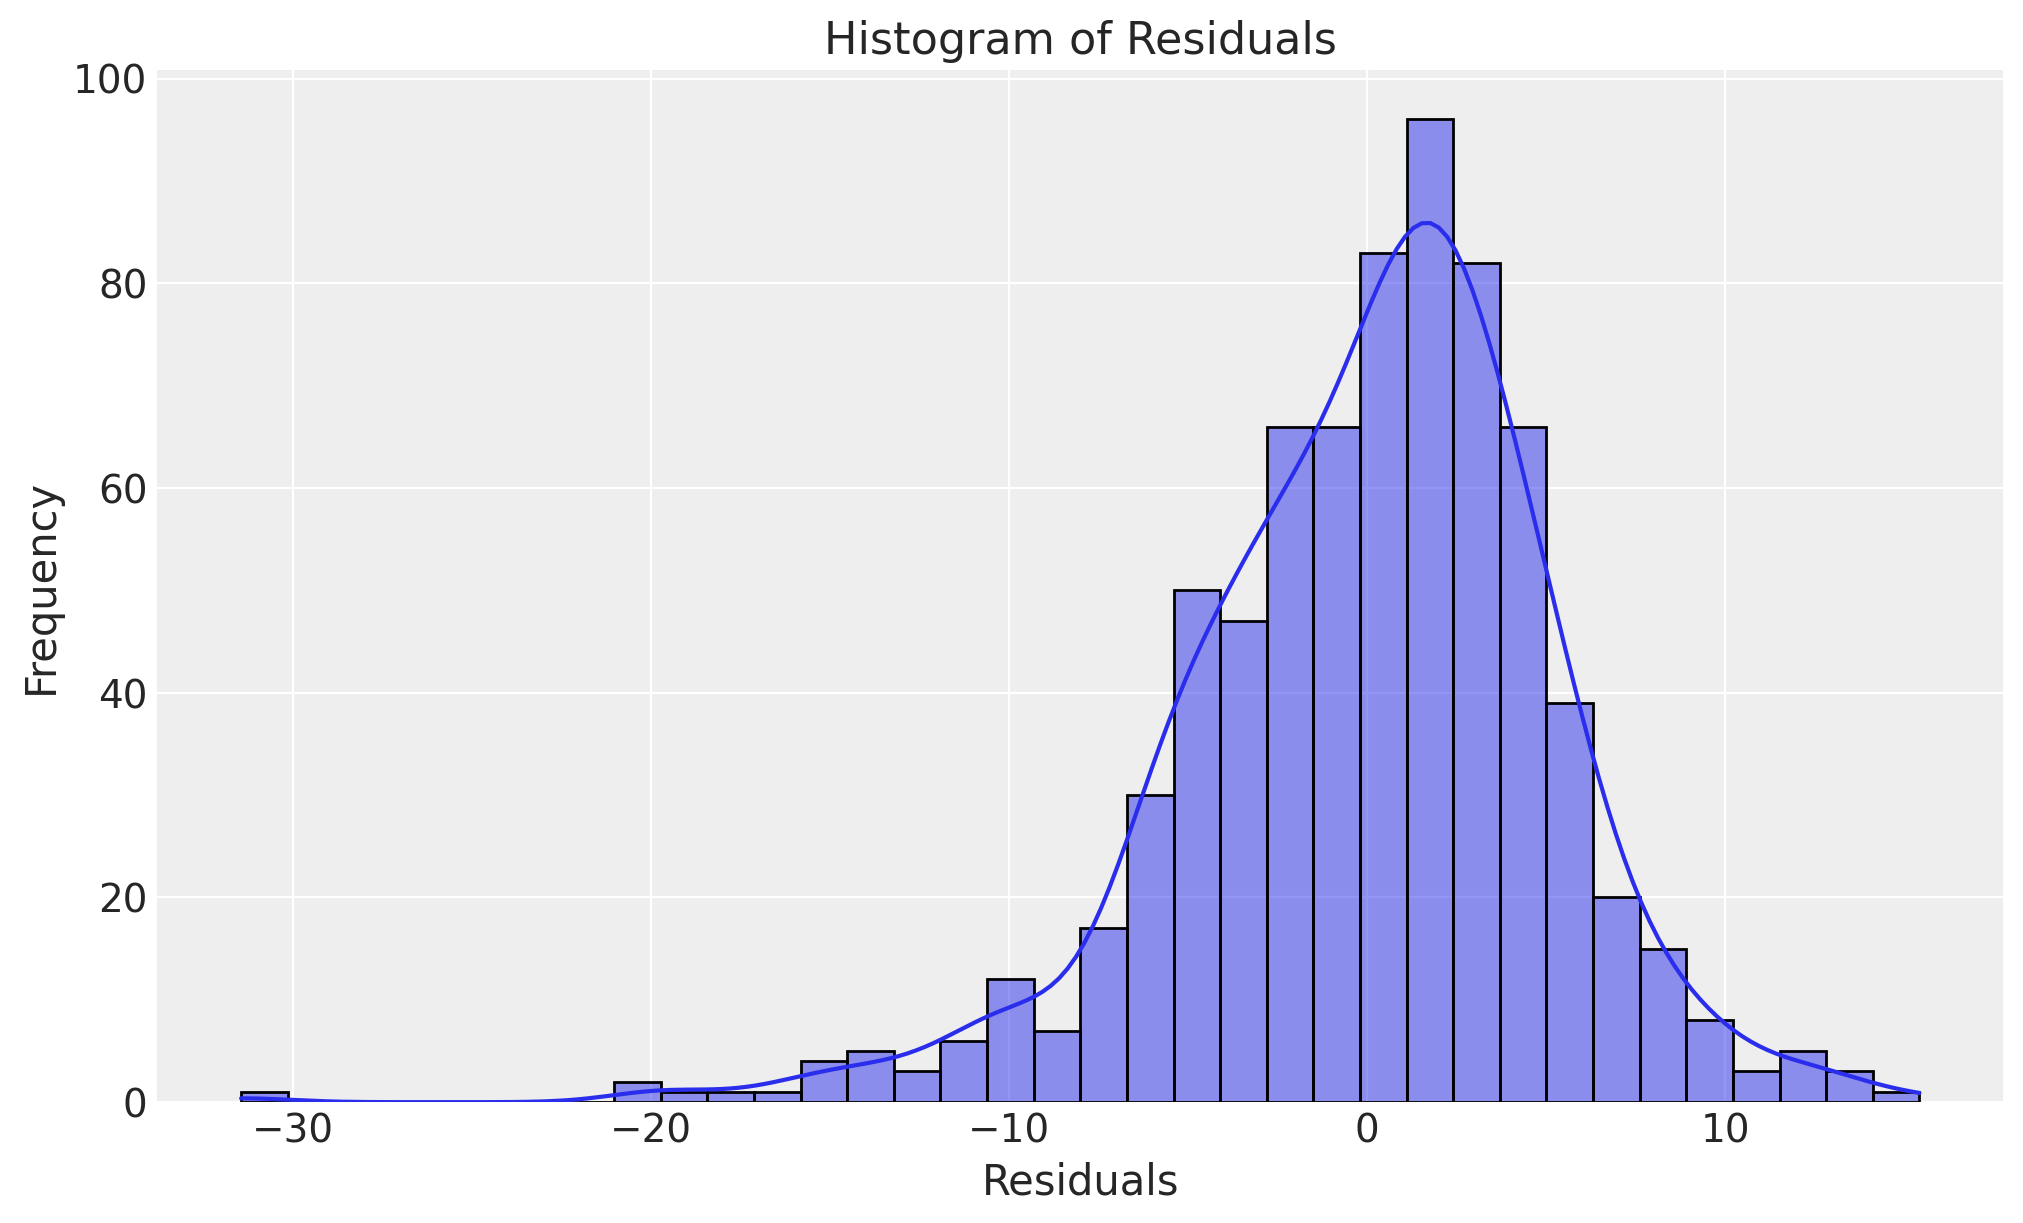

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residual3, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

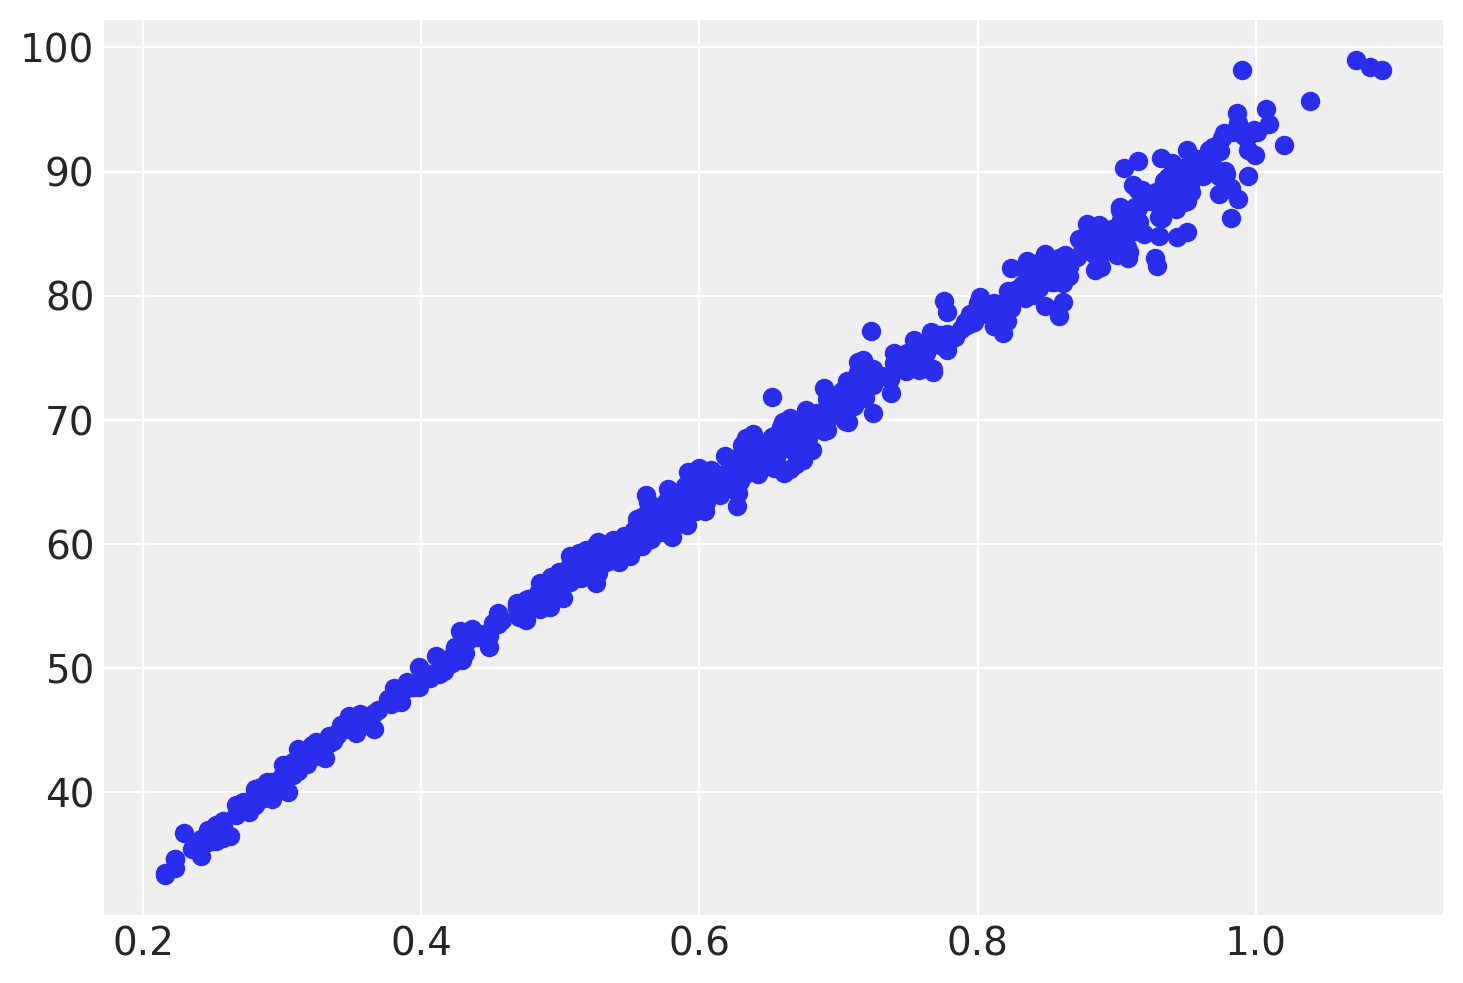

In [40]:
plt.scatter(df['zcmb']**0.333, df['d']**0.2)

In [41]:
reg_4 = stats.linregress(df['zcmb']**0.333, df['d']**0.2)
print(reg_4)

LinregressResult(slope=73.32739274624261, intercept=19.658122106595094, rvalue=0.9968278342165768, pvalue=0.0, stderr=0.21550936897685735, intercept_stderr=0.14181195374233851)


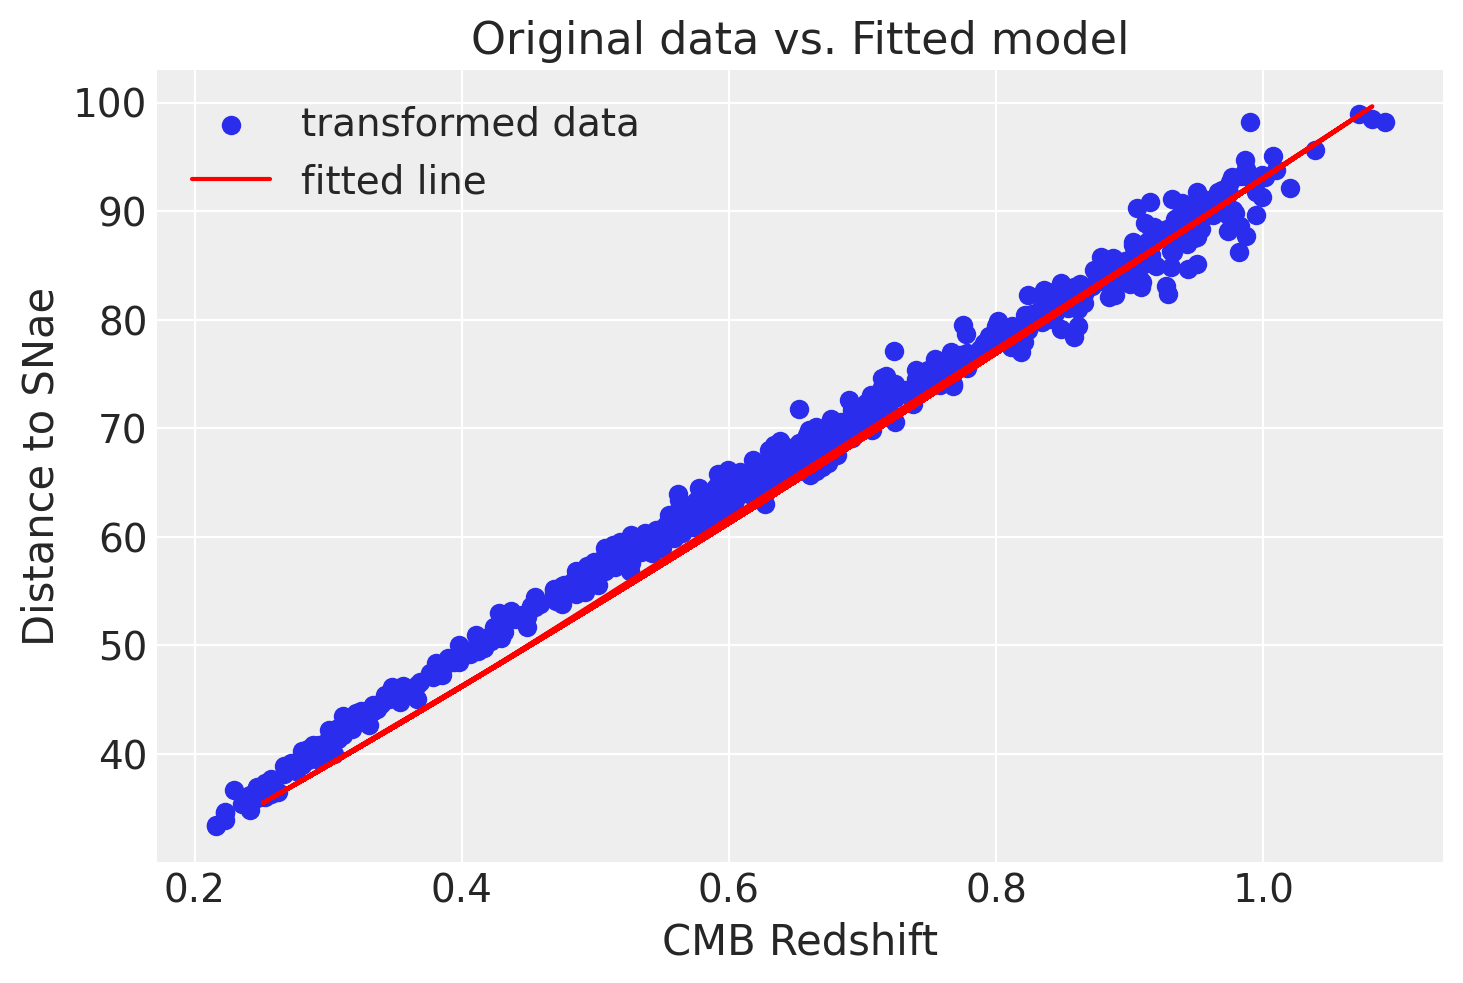

In [42]:
y_pred4 = reg_4.intercept + ((df['zcmb']**0.333) * reg_4.slope)
residual4 = y_pred4 - df['d']**0.2

plt.scatter(df['zcmb']**0.333, df['d']**0.2, label='transformed data')
plt.plot(df['zcmb']**0.3, y_pred4, 'r', label='fitted line')
plt.xlabel('CMB Redshift')
plt.ylabel('Distance to SNae')
plt.title('Original data vs. Fitted model')
plt.legend()
plt.show()

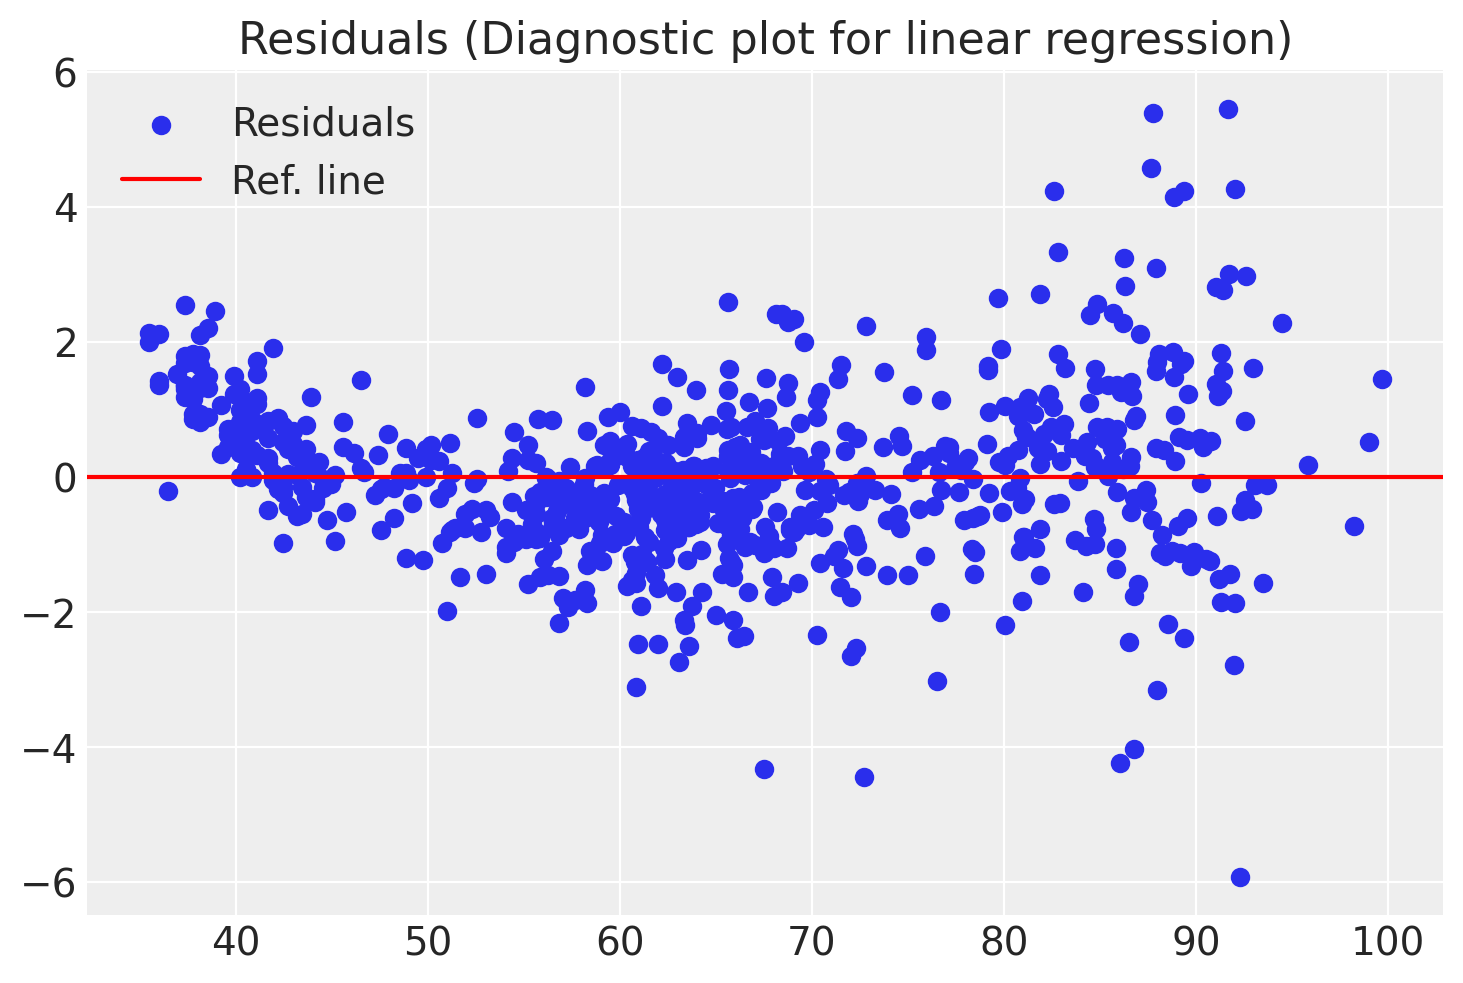

In [43]:
plt.scatter(y_pred4, residual4, label='Residuals')
plt.axhline(y=0, color='r', label='Ref. line')
plt.title('Residuals (Diagnostic plot for linear regression)')
plt.legend()
plt.show()

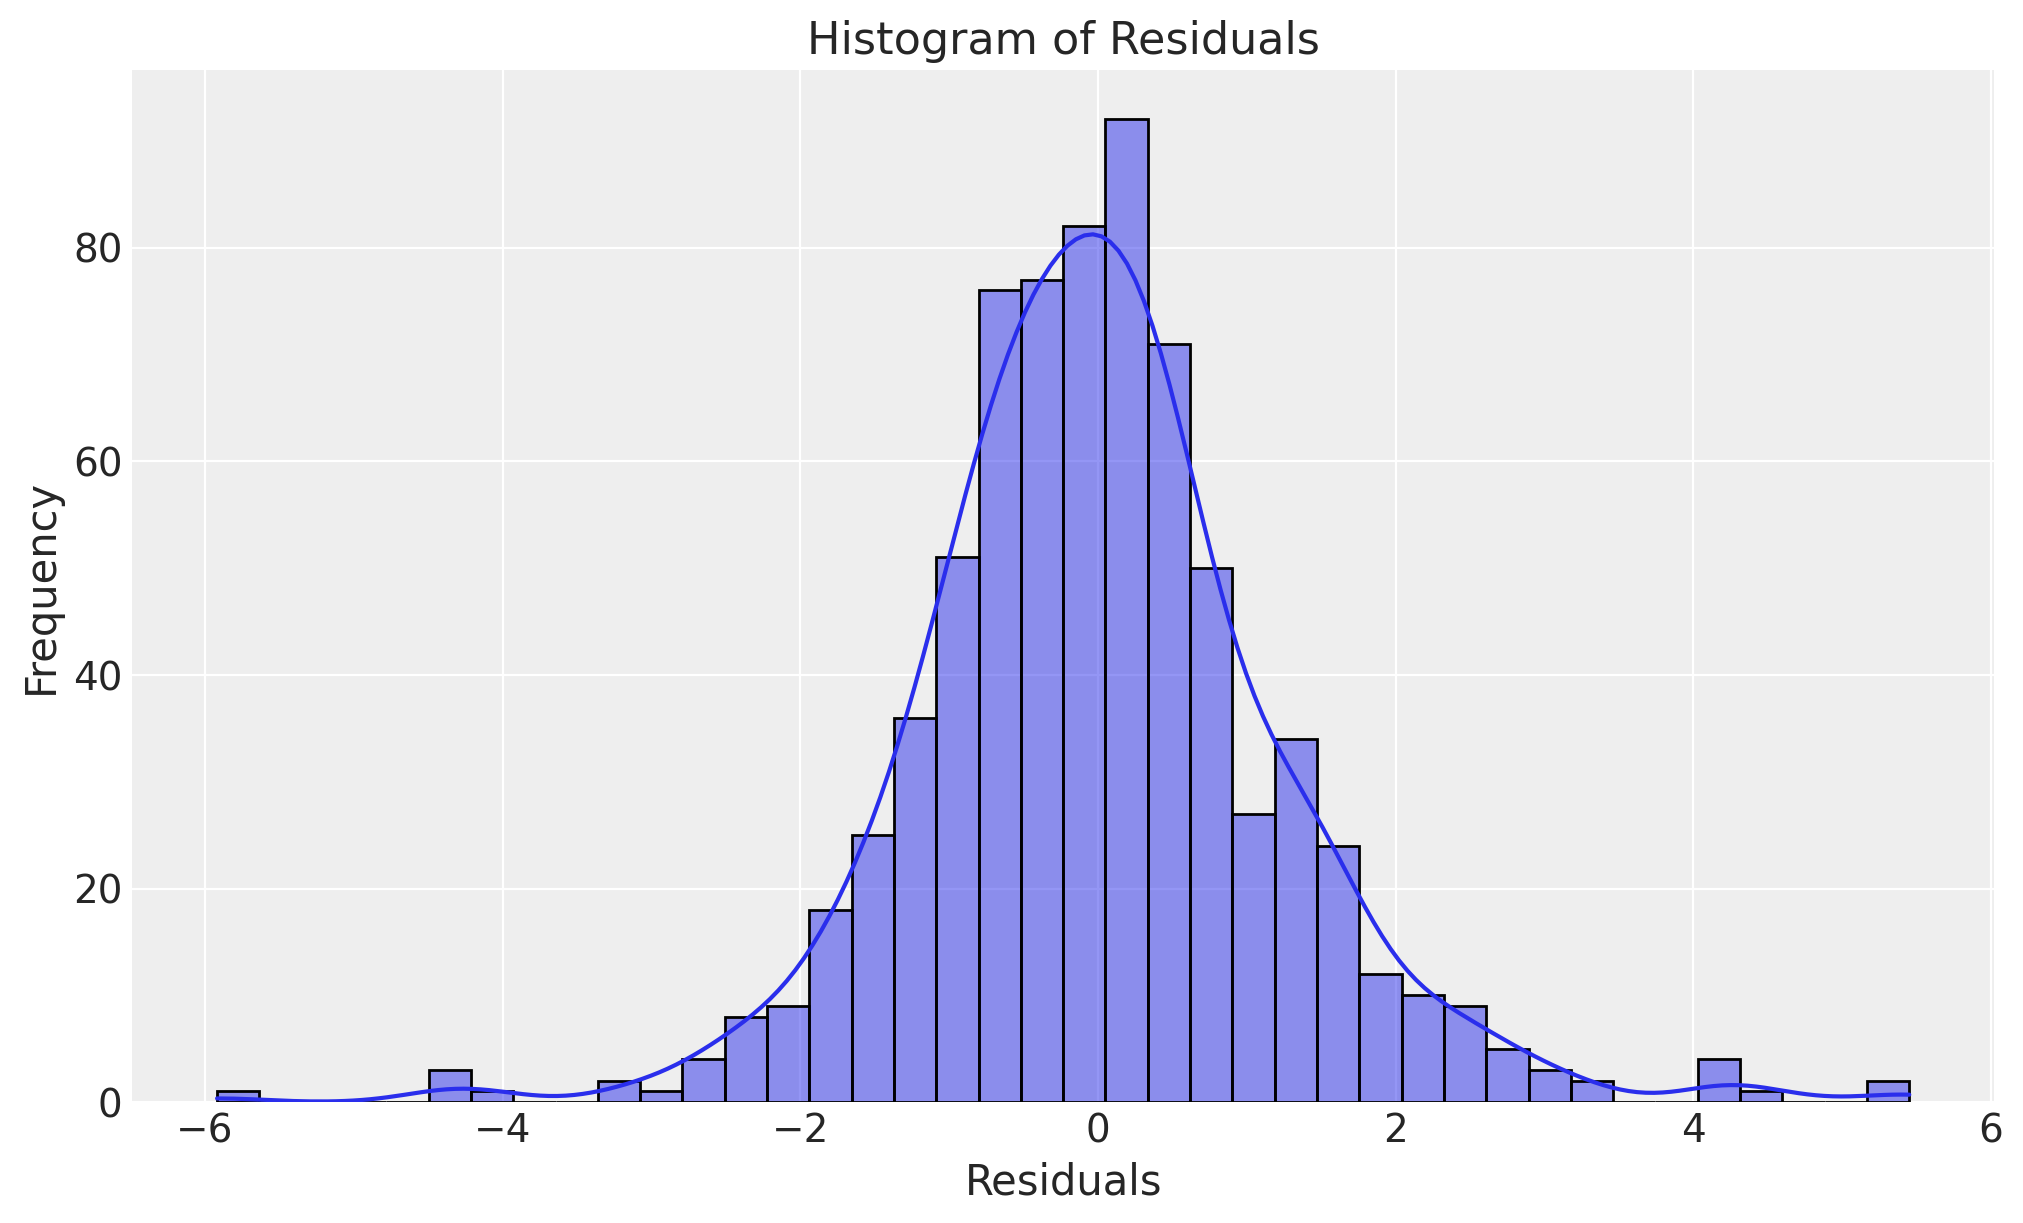

In [44]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residual4, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

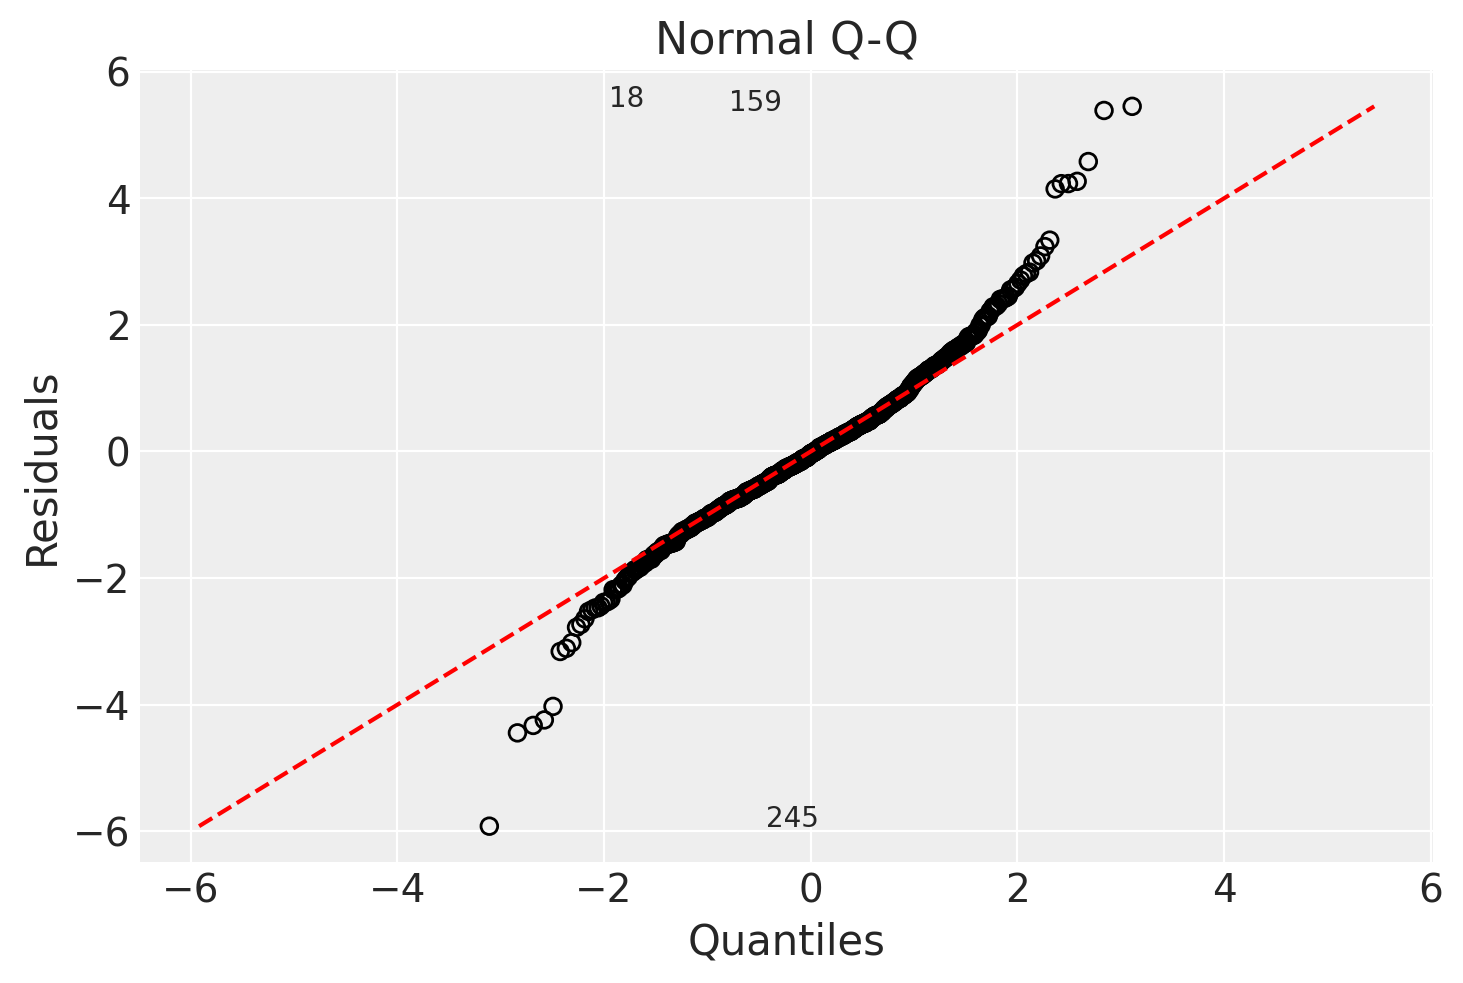

In [54]:
sorted_residual4 = residual4.sort_values(ascending = True)
quantiles = stats.probplot(sorted_residual4, dist = 'norm', fit = False)[0]
rankings = abs(sorted_residual4).sort_values(ascending = False)
# top3 = rankings[:3]
topk = rankings[:3]

fig, ax = plt.subplots()
x = quantiles
y = sorted_residual4
ax.scatter(x, y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Residuals')
ax.set_xlabel('Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in topk.index:
    ax.annotate(val,xy=(pd.Series(quantiles).loc[val], pd.Series(sorted_residual4).loc[val]))
plt.show()

Outliers found from the Normal QQ plot are points 18, 159 and 245. Let's remove these outliers and try fitting the model

In [58]:
# making a copy of the current df to drop outliers
new_df = df.copy()
print(len(df))

740


In [59]:
new_df.drop([18, 159, 245], inplace=True)
print(len(new_df))
print(len(df))

737
740


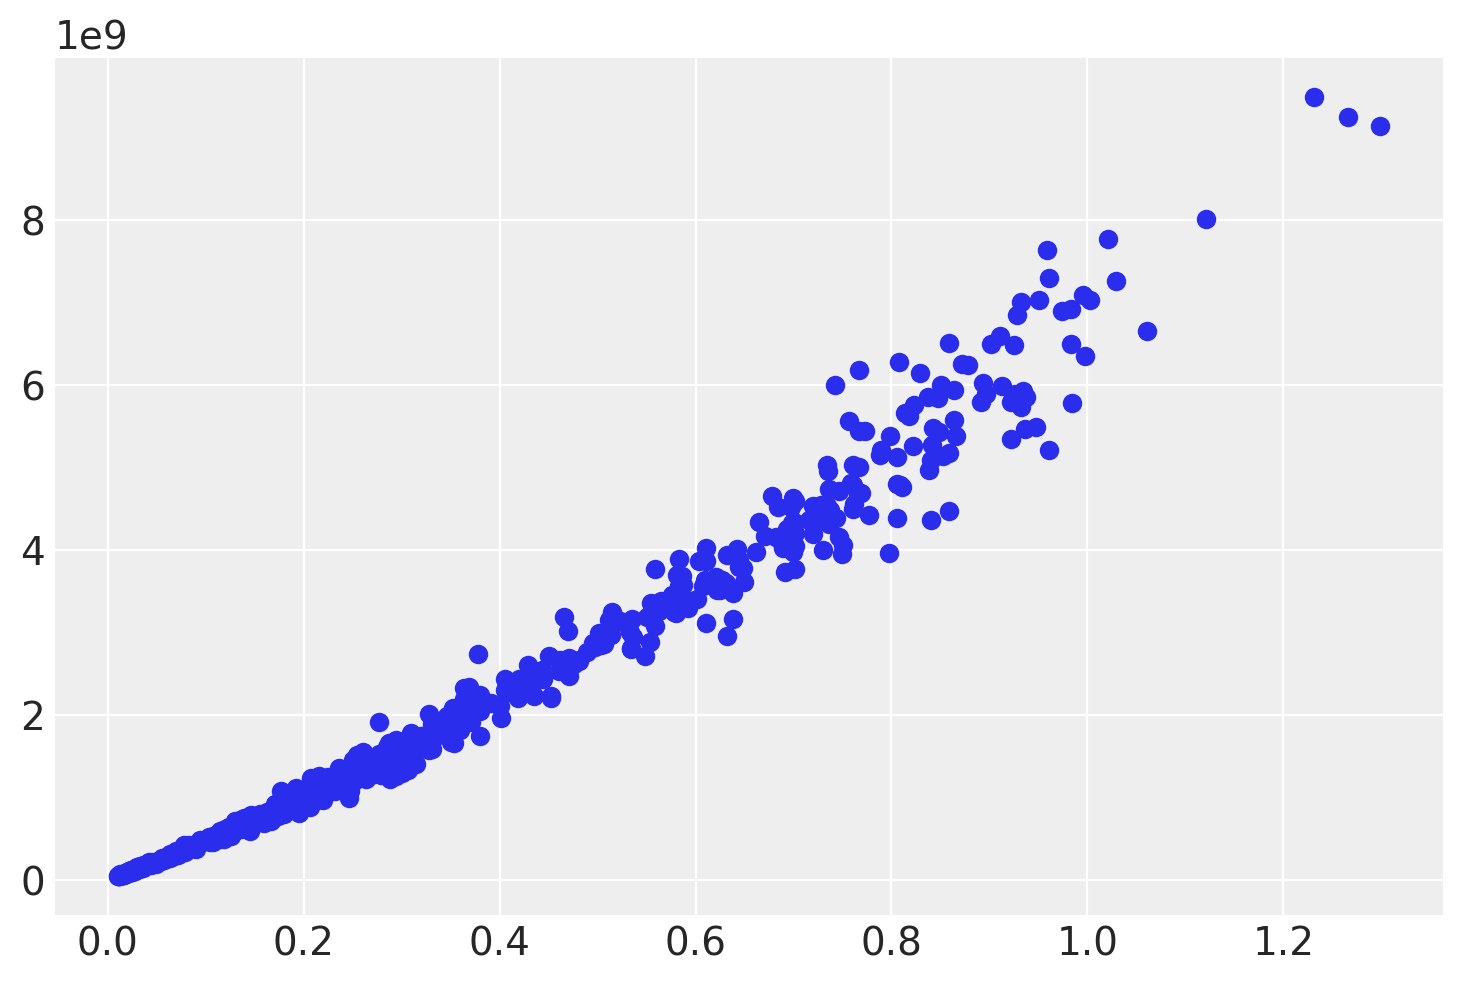

In [64]:
plt.scatter(new_df['zcmb'], new_df['d'])

In [65]:
reg_5 = stats.linregress(new_df['zcmb']**0.333, new_df['d']**0.2)
print(reg_5)

LinregressResult(slope=73.37271702294967, intercept=19.636561532200517, rvalue=0.9970697386417875, pvalue=0.0, stderr=0.20764199406139988, intercept_stderr=0.13631163839532645)


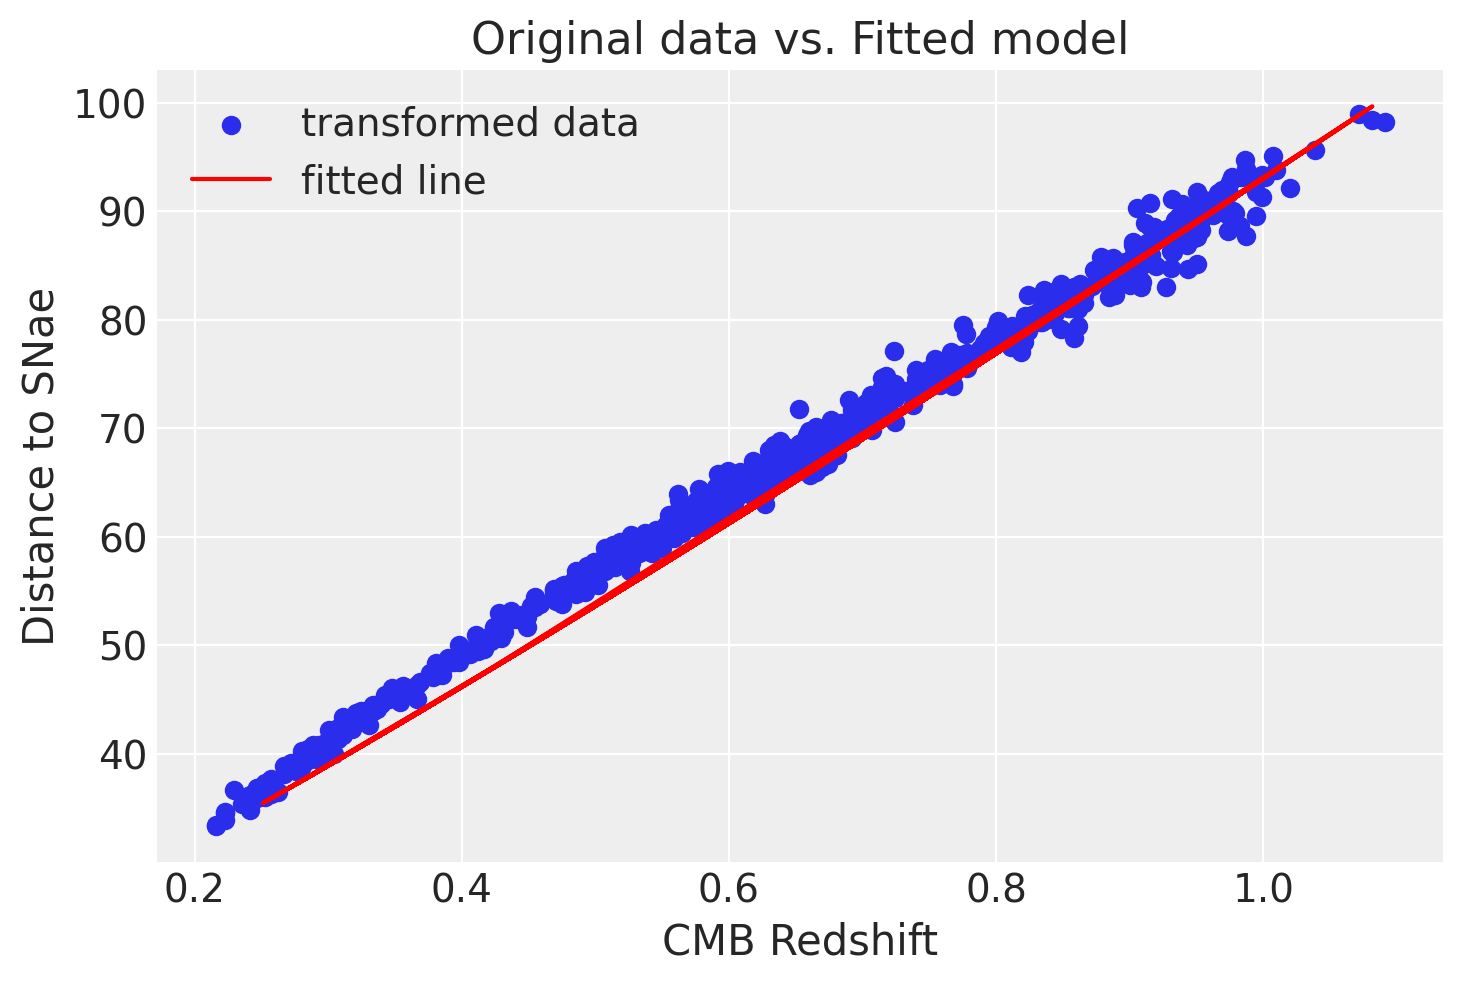

In [61]:
y_pred5 = reg_5.intercept + ((new_df['zcmb']**0.333) * reg_5.slope)
residual5 = y_pred5 - new_df['d']**0.2

plt.scatter(new_df['zcmb']**0.333, new_df['d']**0.2, label='transformed data')
plt.plot(new_df['zcmb']**0.3, y_pred5, 'r', label='fitted line')
plt.xlabel('CMB Redshift')
plt.ylabel('Distance to SNae')
plt.title('Original data vs. Fitted model')
plt.legend()
plt.show()

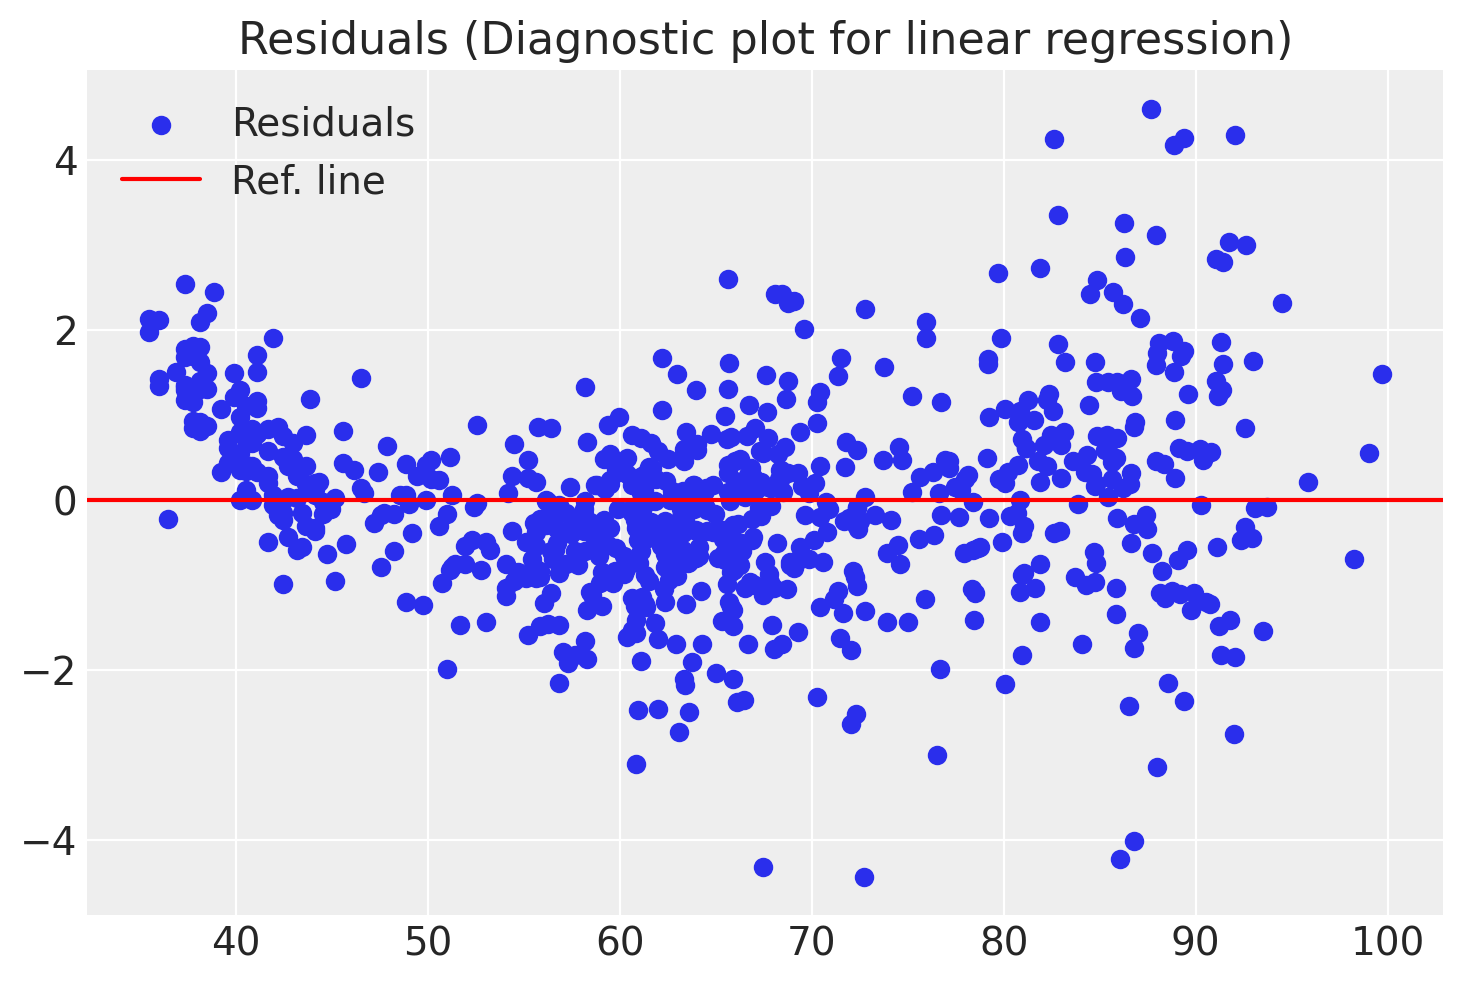

In [67]:
plt.scatter(y_pred5, residual5, label='Residuals')
plt.axhline(y=0, color='r', label='Ref. line')
plt.title('Residuals (Diagnostic plot for linear regression)')
plt.legend()
plt.show()

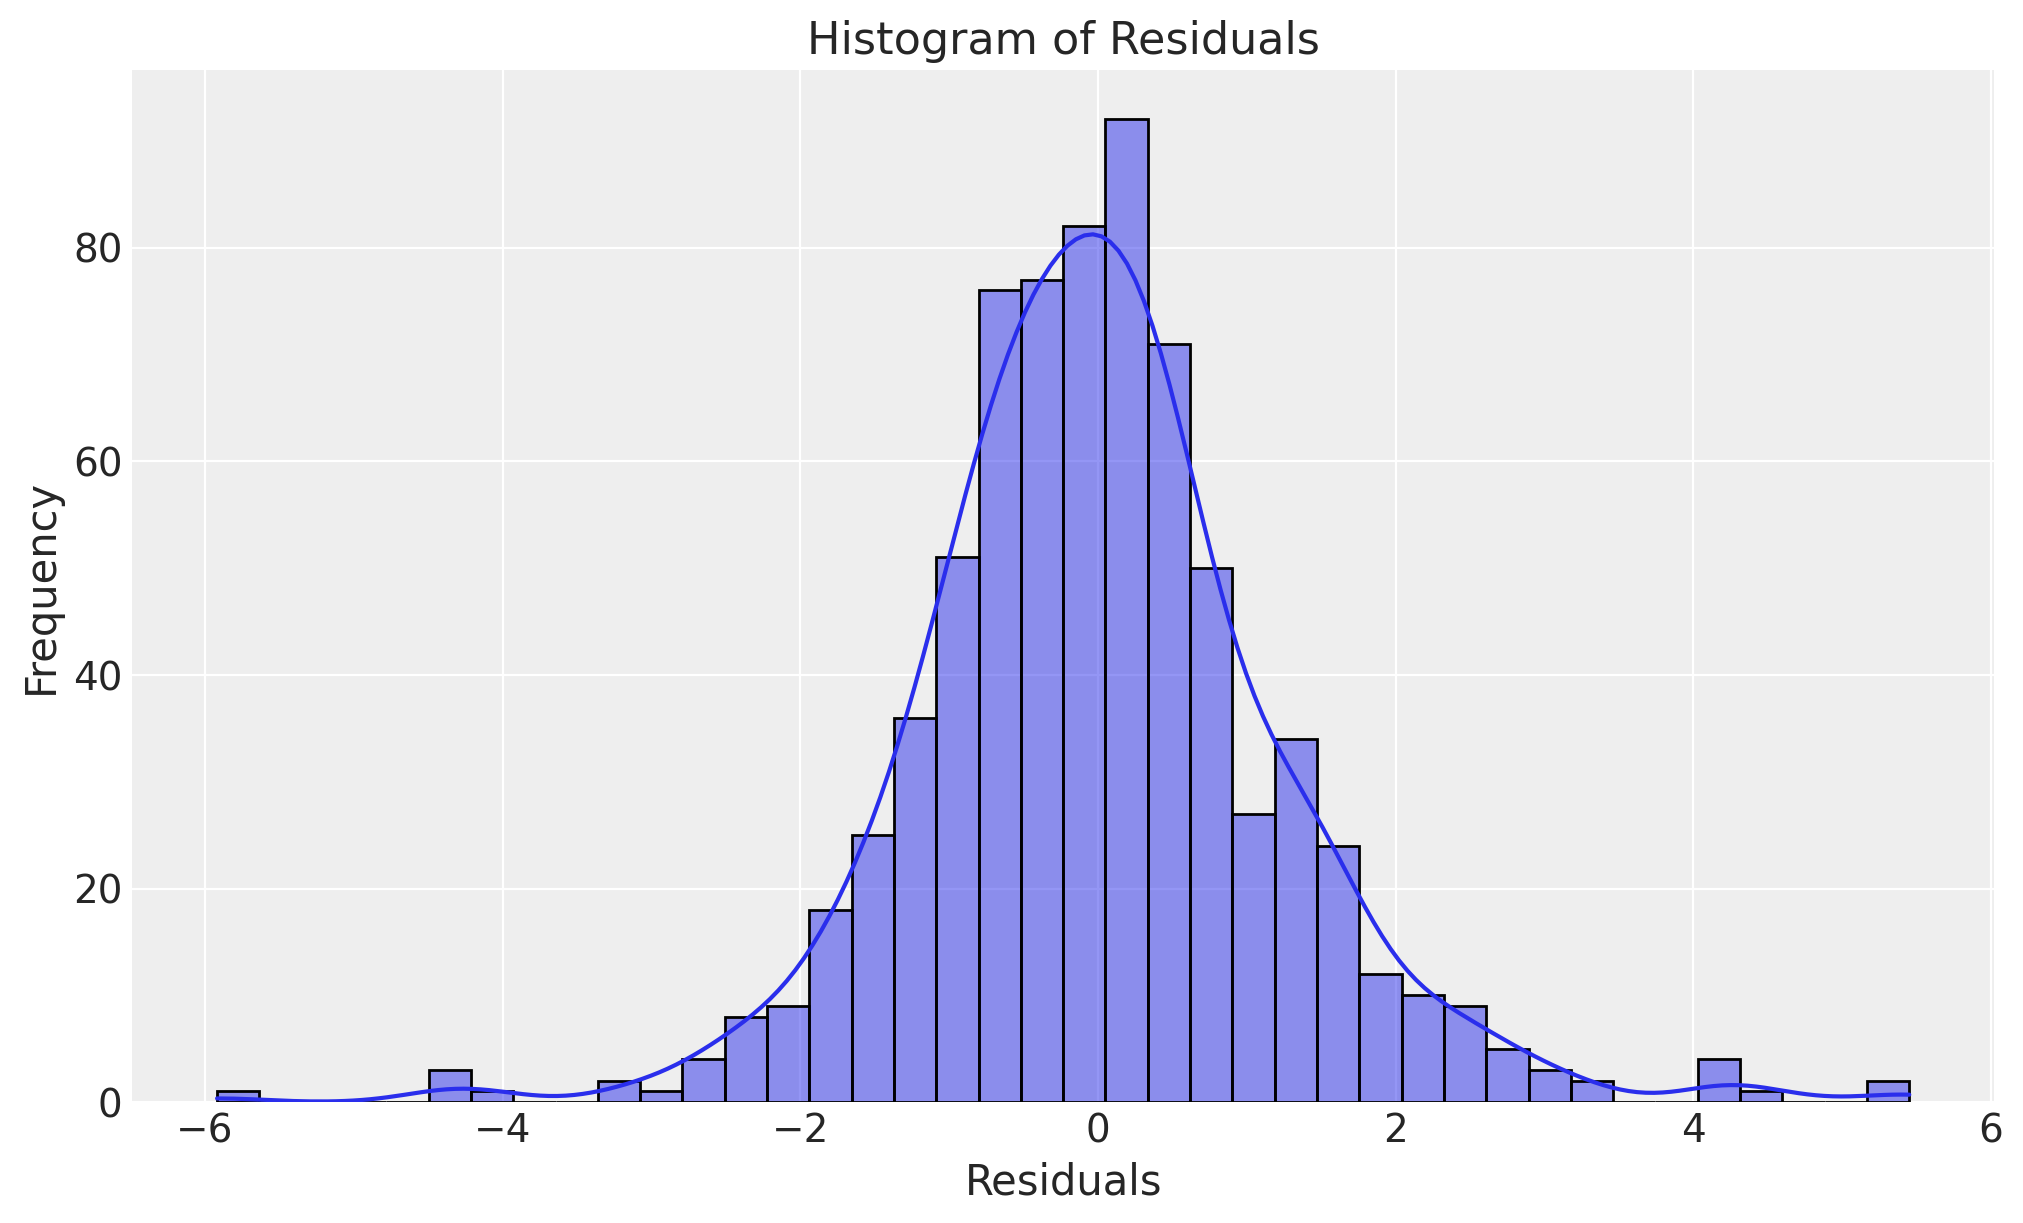

In [68]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residual4, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

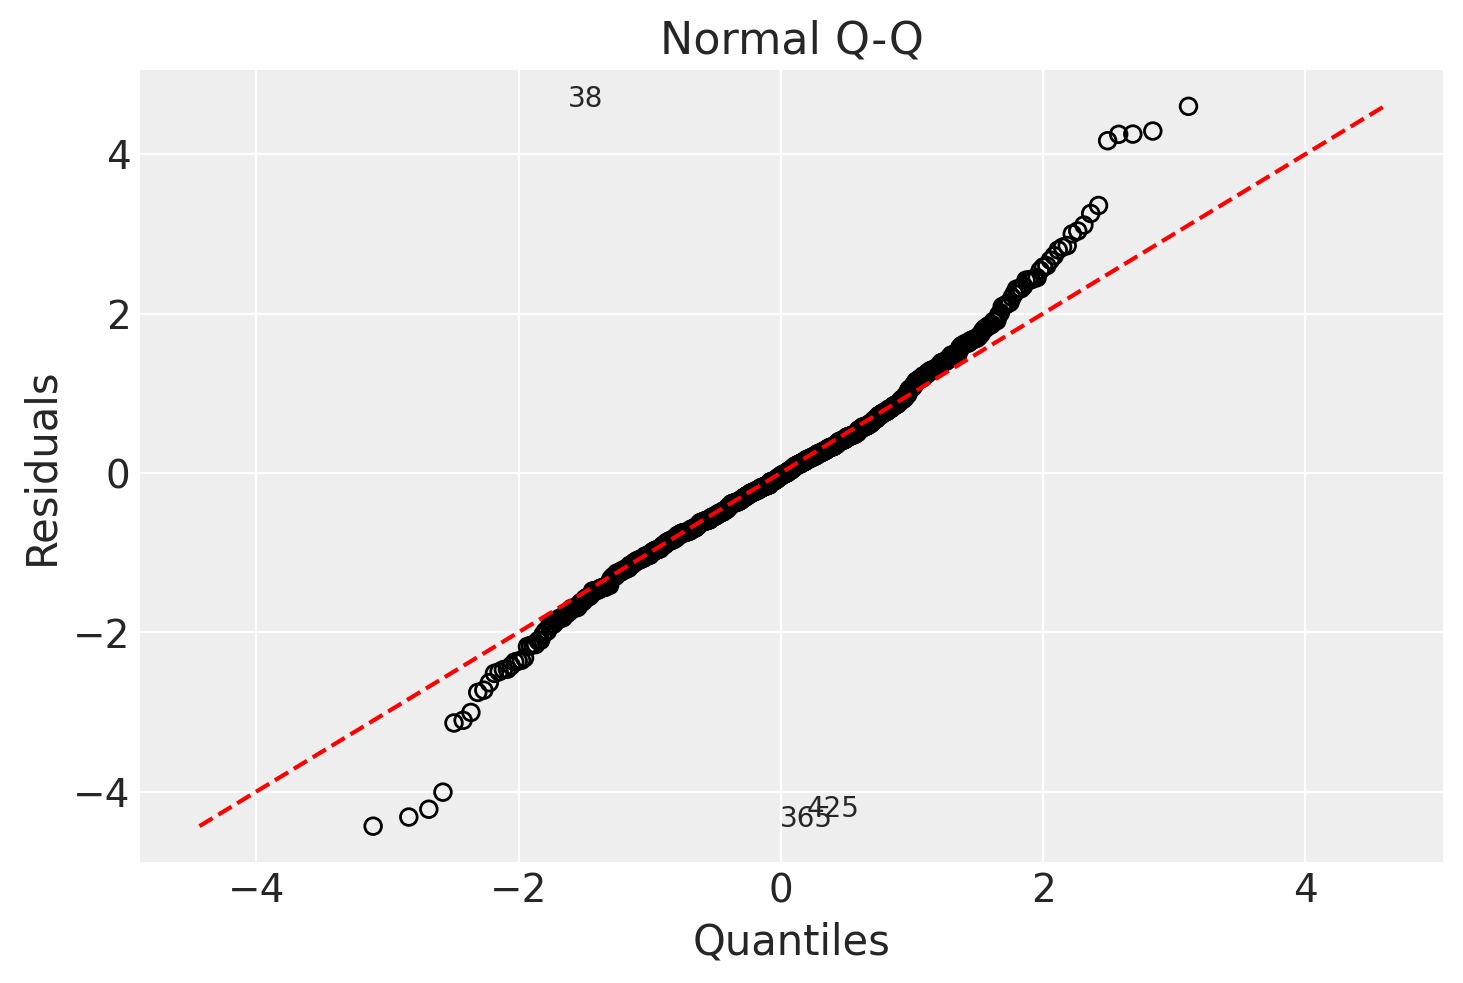

In [69]:
sorted_residual5 = residual5.sort_values(ascending = True)
quantiles = stats.probplot(sorted_residual5, dist = 'norm', fit = False)[0]
rankings = abs(sorted_residual5).sort_values(ascending = False)
# top3 = rankings[:3]
topk = rankings[:3]

fig, ax = plt.subplots()
x = quantiles
y = sorted_residual5
ax.scatter(x, y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Residuals')
ax.set_xlabel('Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in topk.index:
    ax.annotate(val,xy=(pd.Series(quantiles).loc[val], pd.Series(sorted_residual5).loc[val]))
plt.show()

In [ ]:
# Model without errors
with pm.Model() as initial_model:
    x = pm.Data('Z CMB', df.zcmb, mutable=True)
    y = pm.Data('Distance', df.d, mutable=False)
    beta = pm.Normal('beta', mu=0, tau=1./10, shape=2)
    precision = pm.Gamma('precision', alpha=1, beta=1)
    mu = beta[0] + beta[1]*x
    Y_obs = pm.Normal('Y_obs', mu=mu, tau=precision, observed=y)
    start = pm.find_MAP()
    # draw "draws" posterior samples
    ini_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)

<ipython-input-49-bfcd63b69e7e>:10: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  ini_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


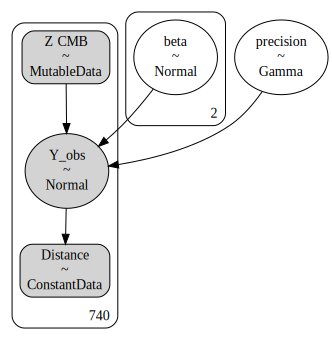

In [ ]:
pm.model_to_graphviz(initial_model)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

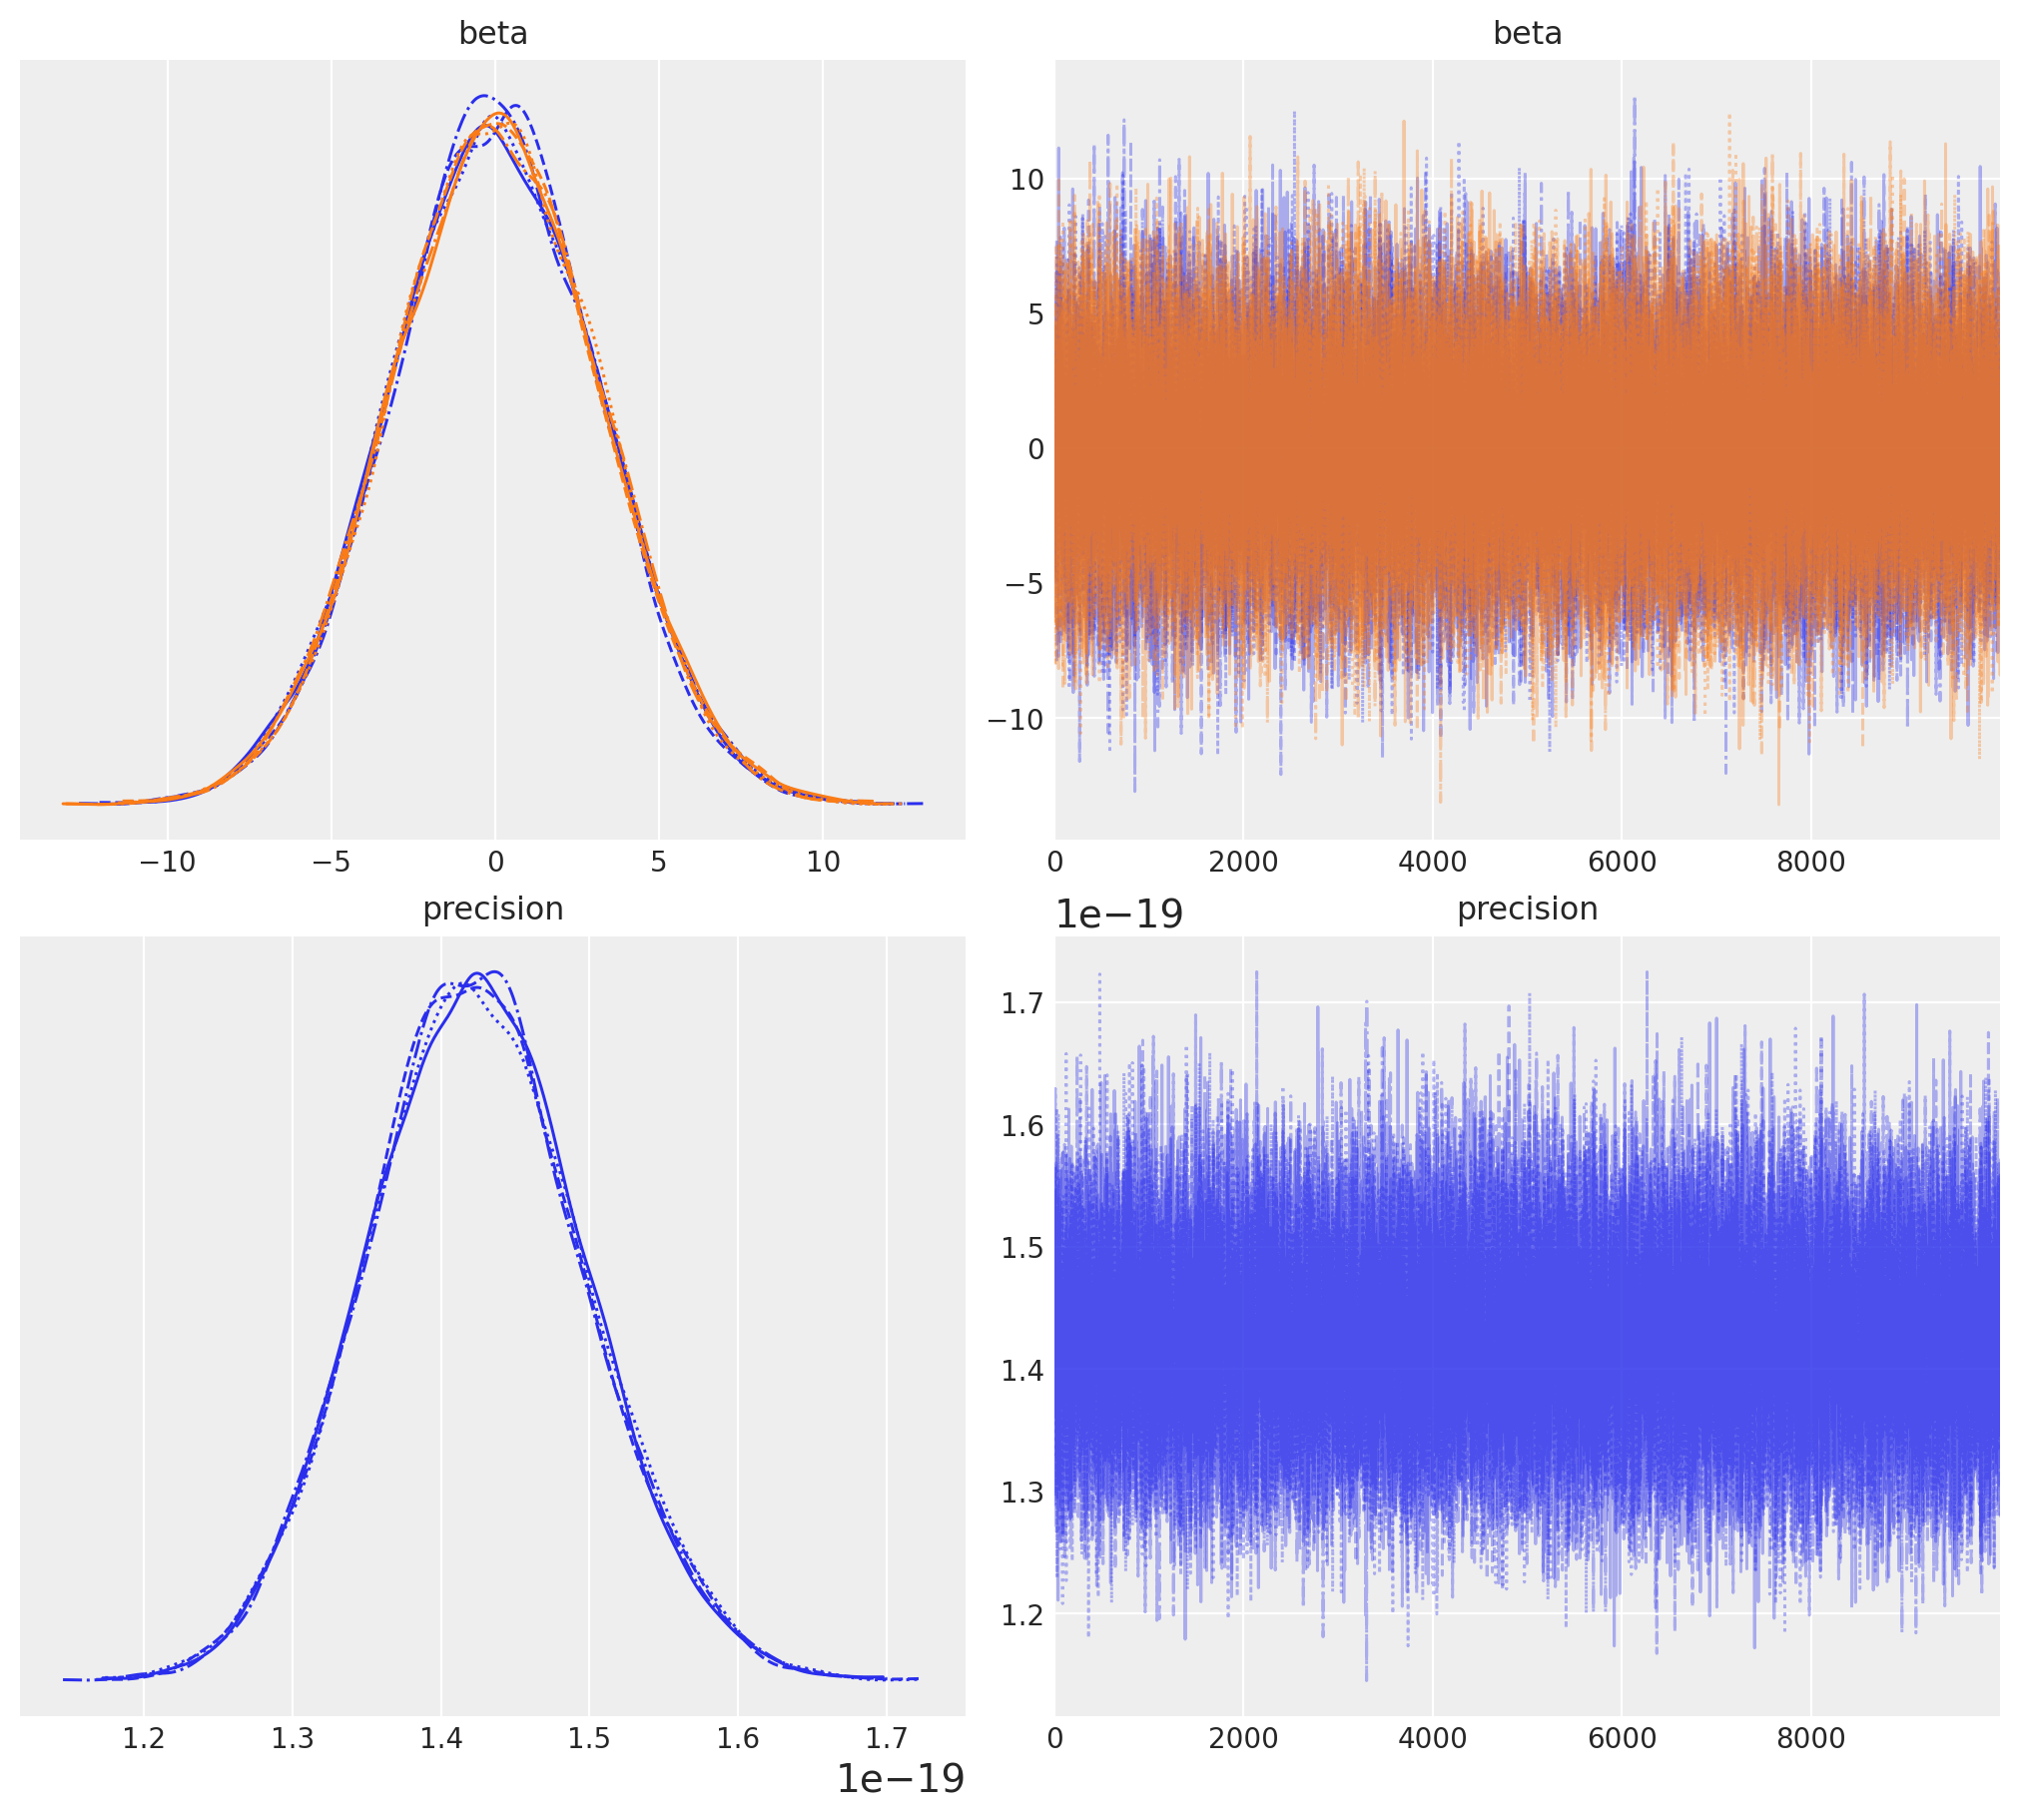

In [ ]:
az.plot_trace(ini_trace,figsize=(10, 9))

In [ ]:
# Power Transformed Model without errors
with pm.Model() as pow_transformed_model:
    x = pm.Data('Z CMB', zcmb_transf, mutable=True)
    y = pm.Data('Distance', d_transf, mutable=False)
    beta = pm.Normal('beta', mu=0, tau=1./10, shape=2)
    precision = pm.Gamma('precision', alpha=1, beta=1)
    mu = beta[0] + beta[1]*x
    Y_obs = pm.Normal('Y_obs', mu=mu, tau=precision, observed=y)
    start = pm.find_MAP()
    # draw "draws" posterior samples
    pow_trans_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)

<ipython-input-33-12f646b573ac>:11: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  pow_trans_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


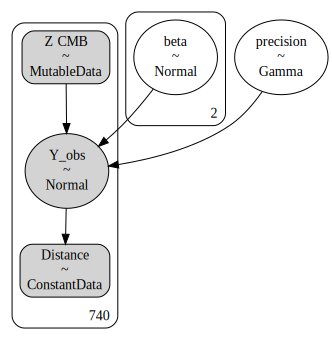

In [ ]:
pm.model_to_graphviz(pow_transformed_model)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

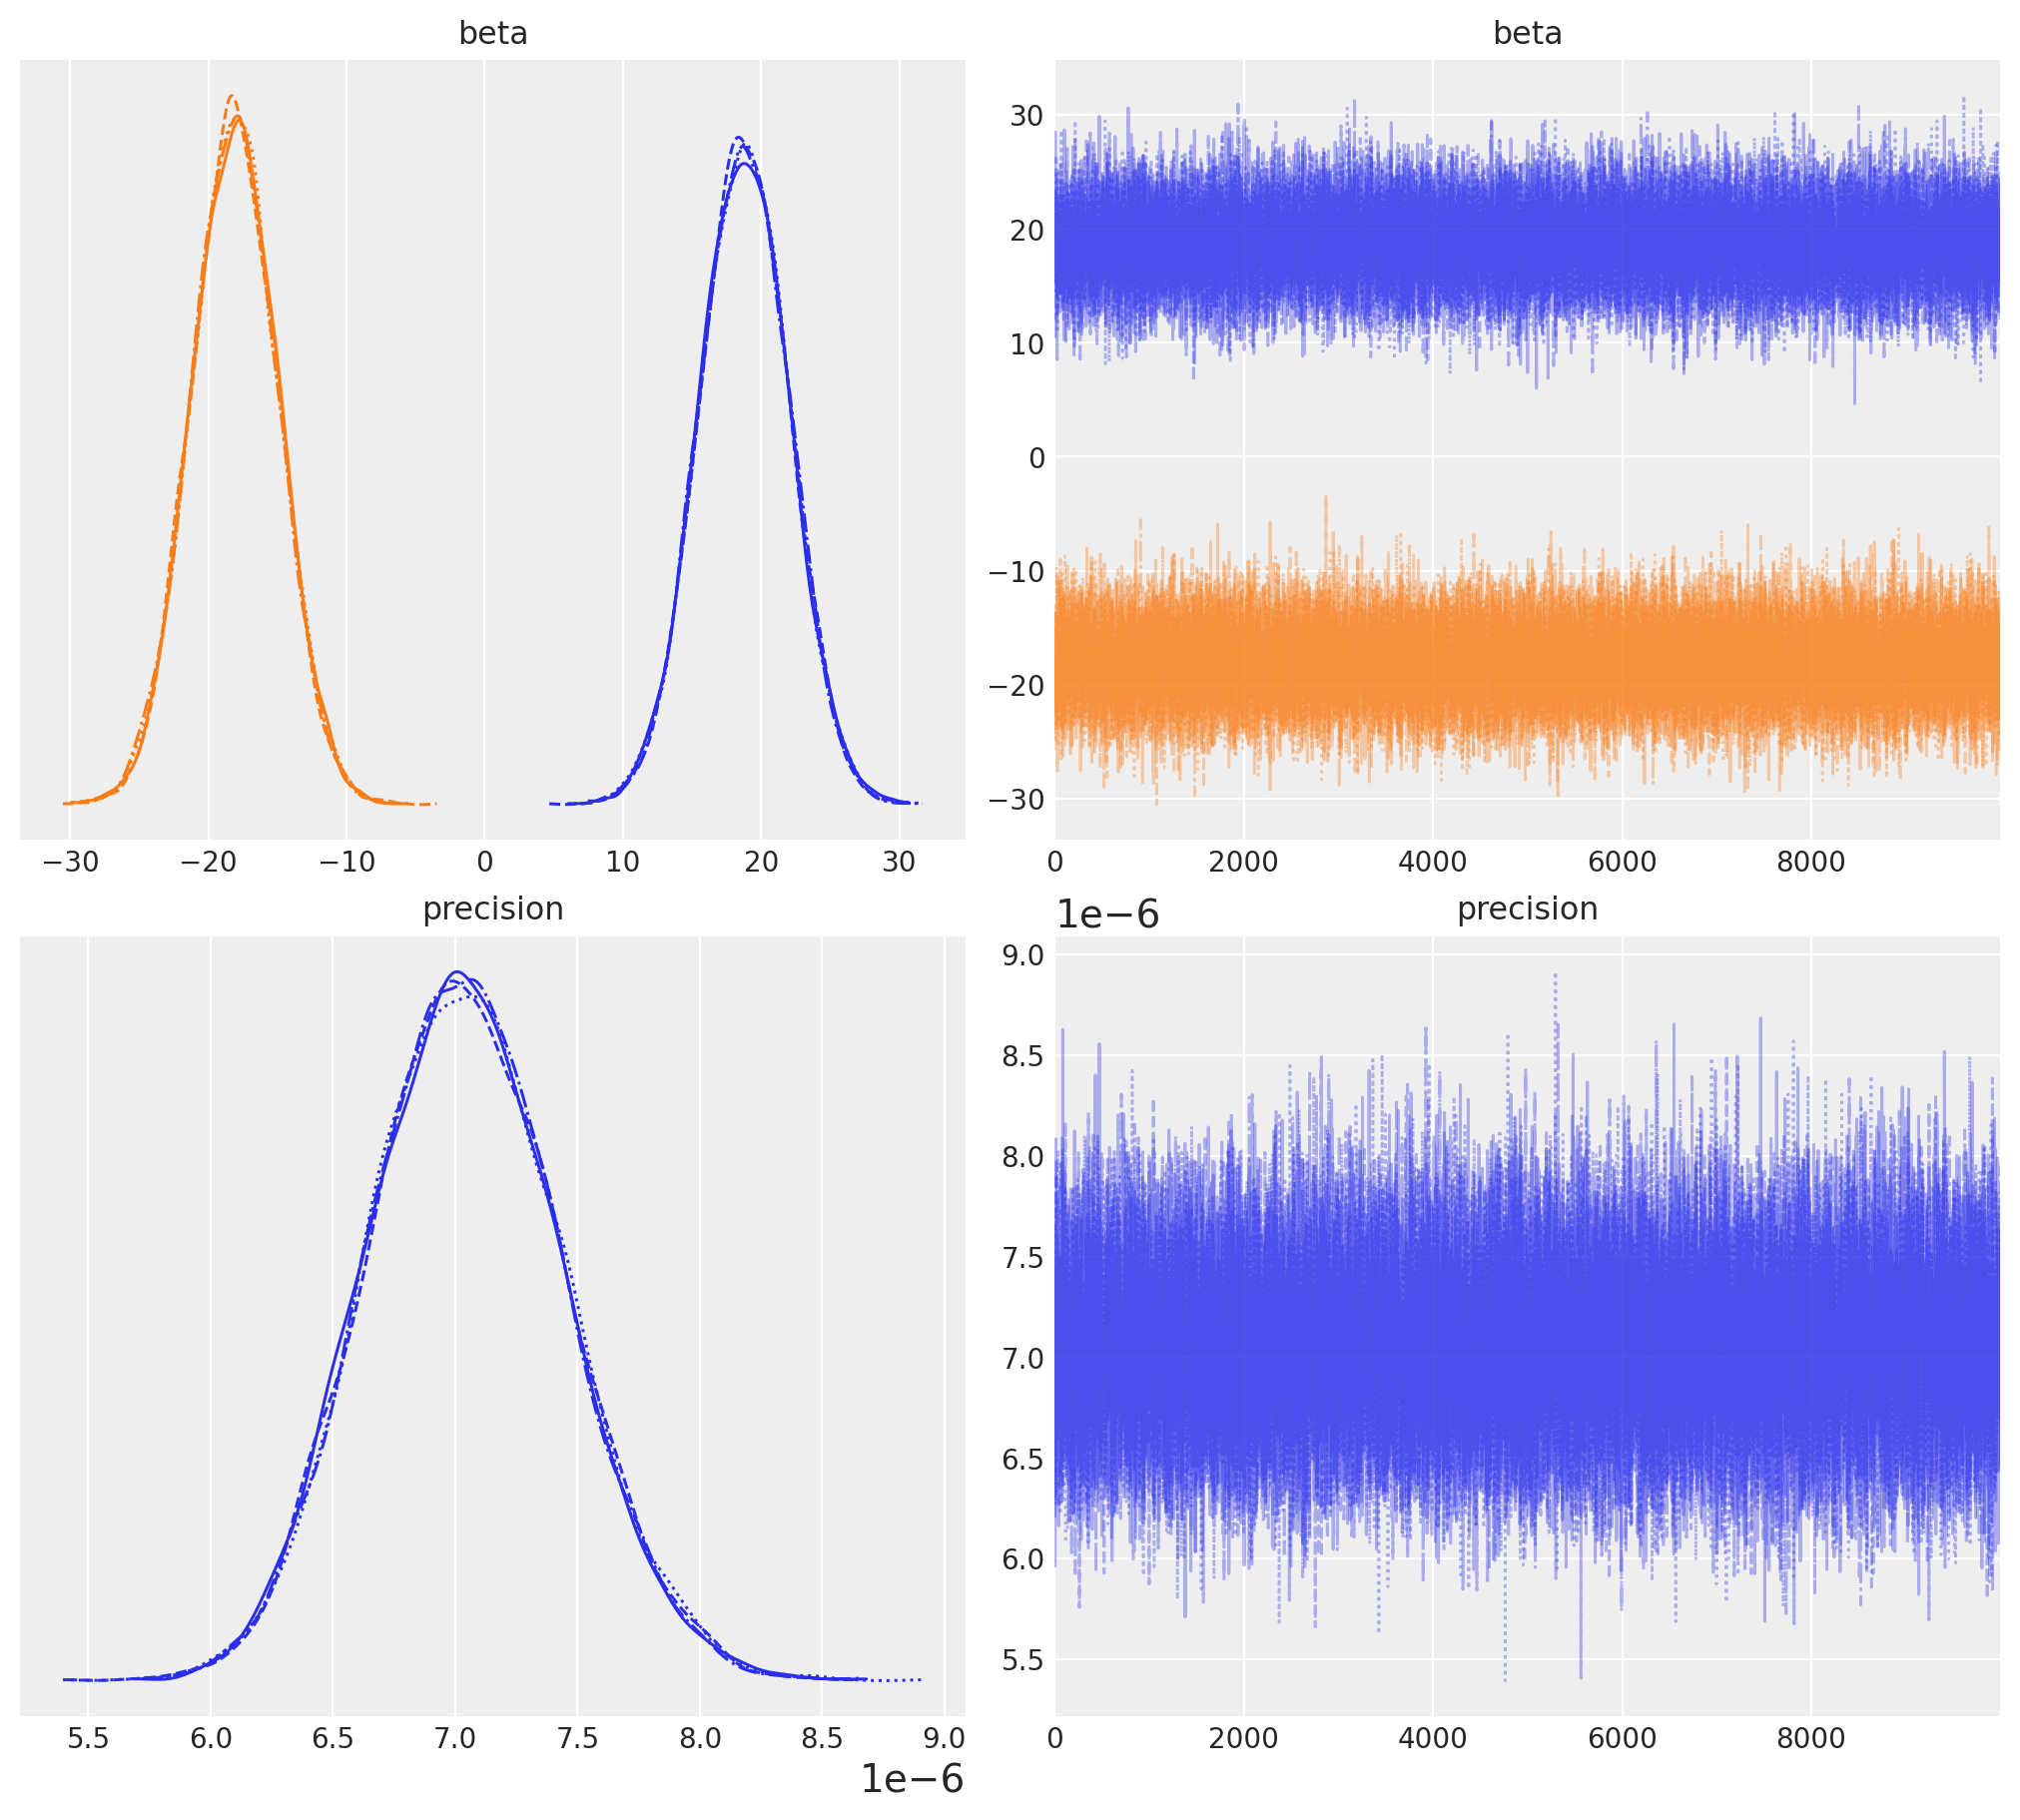

In [ ]:
az.plot_trace(pow_trans_trace, figsize=(10, 9))

In [36]:
# Power Transformed Model (with simpler lambda) without errors
with pm.Model() as pt_model:
    x = pm.Data('Z CMB', df['zcmb']**0.3, mutable=True)
    y = pm.Data('Distance', df['d']**0.2, mutable=False)
    beta = pm.Normal('beta', mu=0, tau=1./10, shape=2)
    precision = pm.Gamma('precision', alpha=1, beta=1)
    mu = beta[0] + beta[1]*x
    Y_obs = pm.Normal('Y_obs', mu=mu, tau=precision, observed=y)
    start = pm.find_MAP()
    # draw "draws" posterior samples
    pt_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)

<ipython-input-36-d08460686145>:11: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  pt_trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=10000)


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


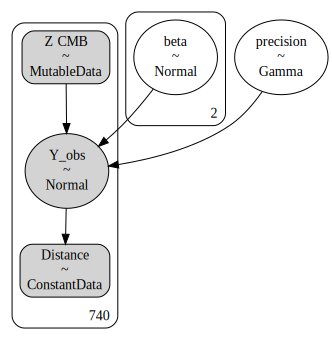

In [37]:
pm.model_to_graphviz(pt_model)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

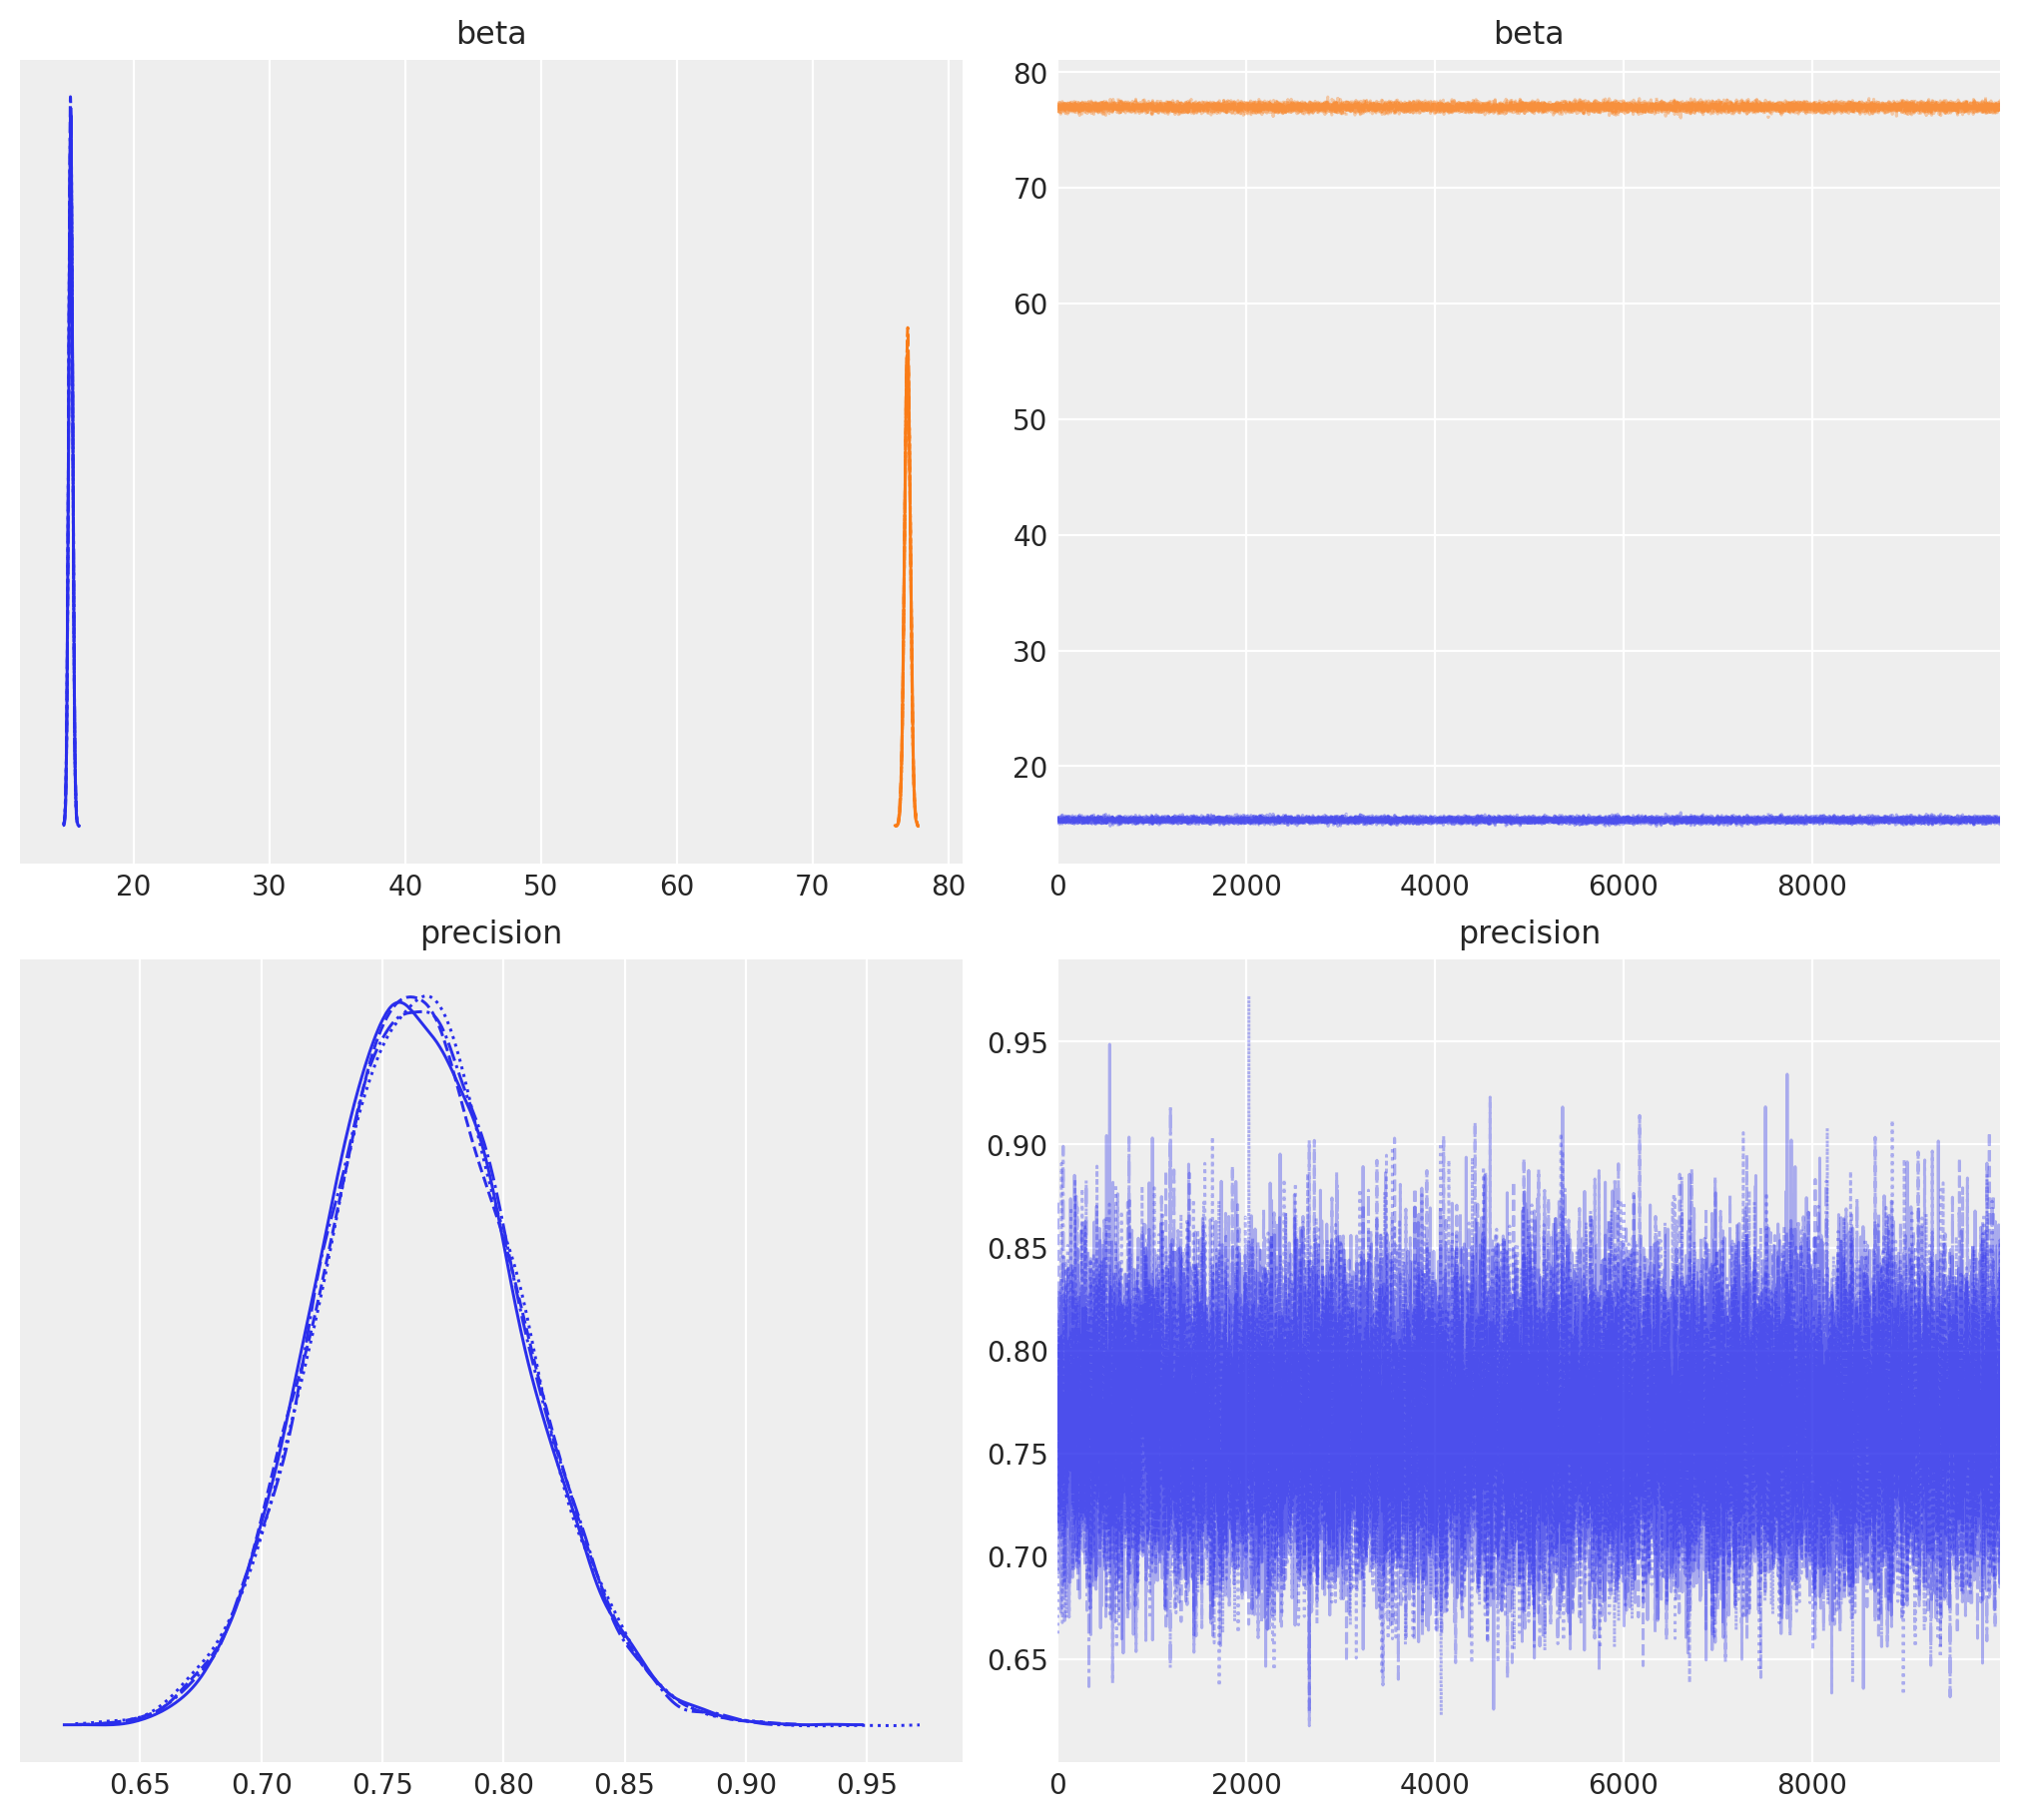

In [38]:
az.plot_trace(pt_trace, figsize=(10, 9))